I use this notebook to investigate why the uncertainty saturates when we extrapolate too far, as illustrated by our energy cold curve predictions.
An argument is that because we extrapolate too far, the output of the activation function saturates.
Especially since the activation function that I use, which is the tanh function, maps the entire real line to values between -1 and 1.
Additionally, this analysis should be paired with the distribution of the weights and bias of the output layer.

Note: The output of the last activation function (i.e., input to the last layer) needs to be generated first, for example using `investigate_saturation_generate.py` Python script.

In [1]:
from pathlib import Path
import json
import pickle
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

# Setup

In [2]:
FILE_DIR = Path().resolve()
ROOT_DIR = FILE_DIR.parent
SETTINGS_DIR = ROOT_DIR / "settings"
structure = "graphene"

In [3]:
# Read setting file and set necessary directories and variables
settings_path = SETTINGS_DIR / "settings0.json"
with open(settings_path, "r") as f:
    settings = json.load(f)
Nnodes = settings["architecture"]["Nnodes"]
RES_DIR = FILE_DIR / "results" / settings_path.with_suffix("").name
nsamples = 100

# Last layer weights and bias

In [4]:
# Load parameters
last_layer_params = []
for ii in tqdm(range(nsamples)):
    sample_dir = RES_DIR / f"{ii:03d}"
    last_layer_params.append(np.load(sample_dir / "last_params.npy")[-(Nnodes[-1]+1):])
last_layer_params = np.vstack(last_layer_params)

100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 263.75it/s]


In [5]:
# Statistics
llp_mean = np.mean(last_layer_params, axis=0)
llp_std = np.std(last_layer_params, axis=0)

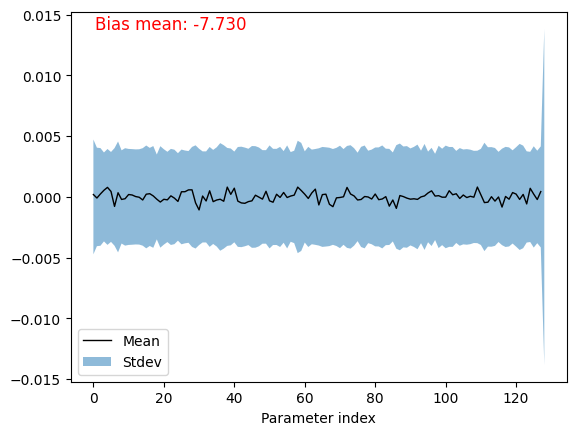

In [6]:
# Plots
plt.figure()
plt.plot(range(len(llp_mean) - 1), llp_mean[:-1], lw=1, c="k", zorder=10, label="Mean")
plt.fill_between(range(len(llp_std)), -llp_std, llp_std, alpha=0.5, label="Stdev")
plt.text(0.5, max(llp_std), f"Bias mean: {llp_mean[-1]:.3f}", fontsize=12, color="red")
plt.xlabel("Parameter index")
plt.legend()
plt.show()

In [7]:
# for ii, ens in enumerate(last_layer_params.T):
#     plt.figure()
#     plt.title(f"Parameter index {ii}")
#     plt.hist(ens, density=True, bins=10)
# plt.show()

# Last activation function

In [8]:
# Load the data
output_activation = []
for ii in tqdm(range(nsamples)):
    sample_dir = RES_DIR / f"{ii:03d}"
    with open(sample_dir / f"input_last_layer_{structure}.pkl", "rb") as f:
        output = pickle.load(f)
    try:
        output_activation.append(np.swapaxes(np.array(output), 0, 1))
    except:
        print(ii)
        continue
output_activation = np.concatenate(output_activation, axis=0)
nlat_params = output_activation.shape[1]

100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 307.31it/s]


In [9]:
output_activation_mean = np.mean(output_activation, axis=0)
output_activation_std = np.std(output_activation, axis=0)

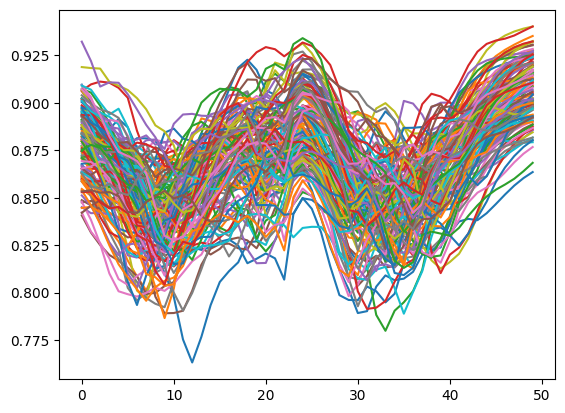

In [10]:
plt.figure()
for val in output_activation_std.T:
    plt.plot(val)
plt.show()

## Validation

If I extracted the input of the last layer correctly, I should be able to reconstruct the prediction mean and standard deviation from a simple linear mapping of these input values and the weights and bias.

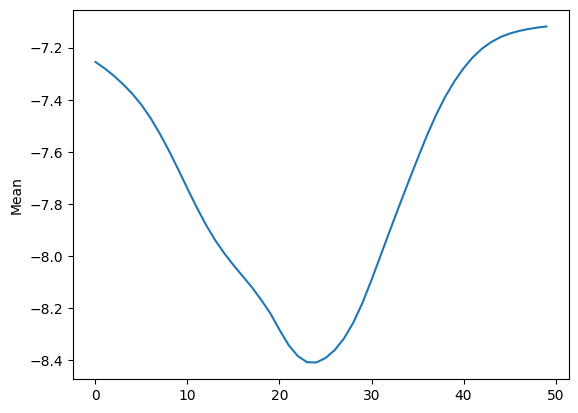

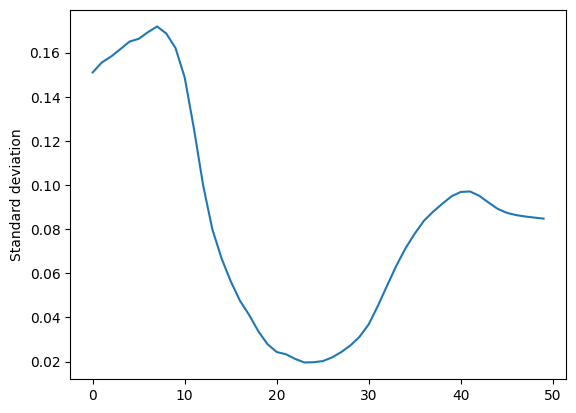

In [11]:
output_validation = np.empty((nsamples, nlat_params))
for ii in range(nsamples):
    for jj in range(nlat_params):
        output_validation[ii, jj] = sum(output_activation[2*ii:2*(ii+1), jj] @ last_layer_params[ii, :-1]) + last_layer_params[ii, -1]

val_mean = np.mean(output_validation, axis=0)
val_std = np.std(output_validation, axis=0)

plt.figure()
plt.plot(range(nlat_params), val_mean)
plt.ylabel("Mean")

plt.figure()
plt.plot(range(nlat_params), val_std)
plt.ylabel("Standard deviation")
plt.show()

## Comparative analysis

I don't want to look at all lattice parameter.
Here, I only pick several locations that I think cover the interesting regime, such as: far left, left uncertainty peak, DFT minimum, right uncertainty peak, and far right.

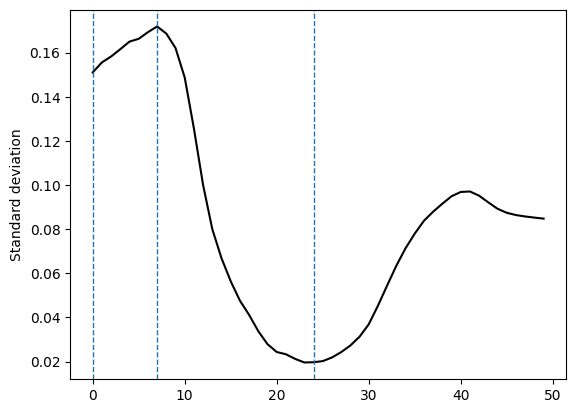

In [28]:
# These indices point to the 6 lattice parameters that I am interested in
if structure == "diamond":
    aidx = [0, 4, 7, 9, 17, 20]
elif structure == "graphene":
    # aidx = [0, 10, 15, 19, 25, 38, 42, 49]
    aidx = [0, 7, 24]
elif structure == "graphite":
    aidx = [0, 6, 15, 19, 25, 38, 42, 49]

plt.figure()
plt.plot(range(nlat_params), val_std, c="k")
for ai in aidx:
    plt.axvline(ai, ls="--", lw=1)
plt.ylabel("Standard deviation")
plt.show()

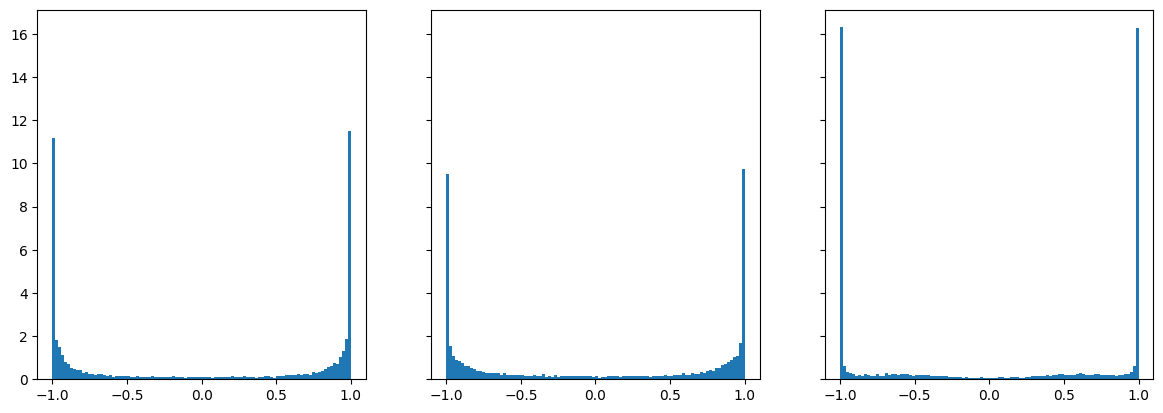

In [30]:
# Aggregate the results
combined = np.empty((0, 50))
for j in range(128):
    combined = np.vstack((combined, output_activation[:, :, j]))

# Plot
fig, axes = plt.subplots(1, len(aidx), figsize=(4.8 * len(aidx), 4.8), sharey=True)
for jj, ai in enumerate(aidx):
    ax = axes[jj]
    ax.hist(combined[:, ai], density=True,bins=100)
plt.show()

/tmp/ipykernel_3224306/702768160.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, len(aidx) + 1, figsize=(4.8 * (len(aidx) + 1), 4.8))


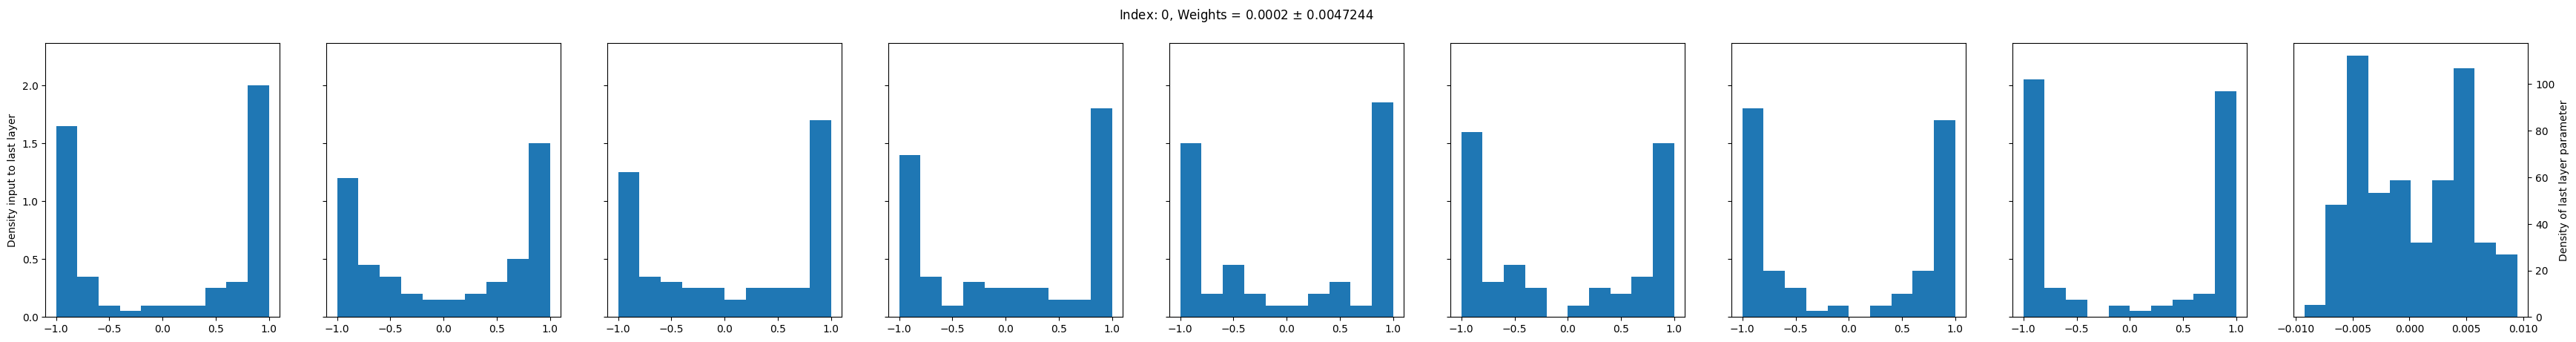

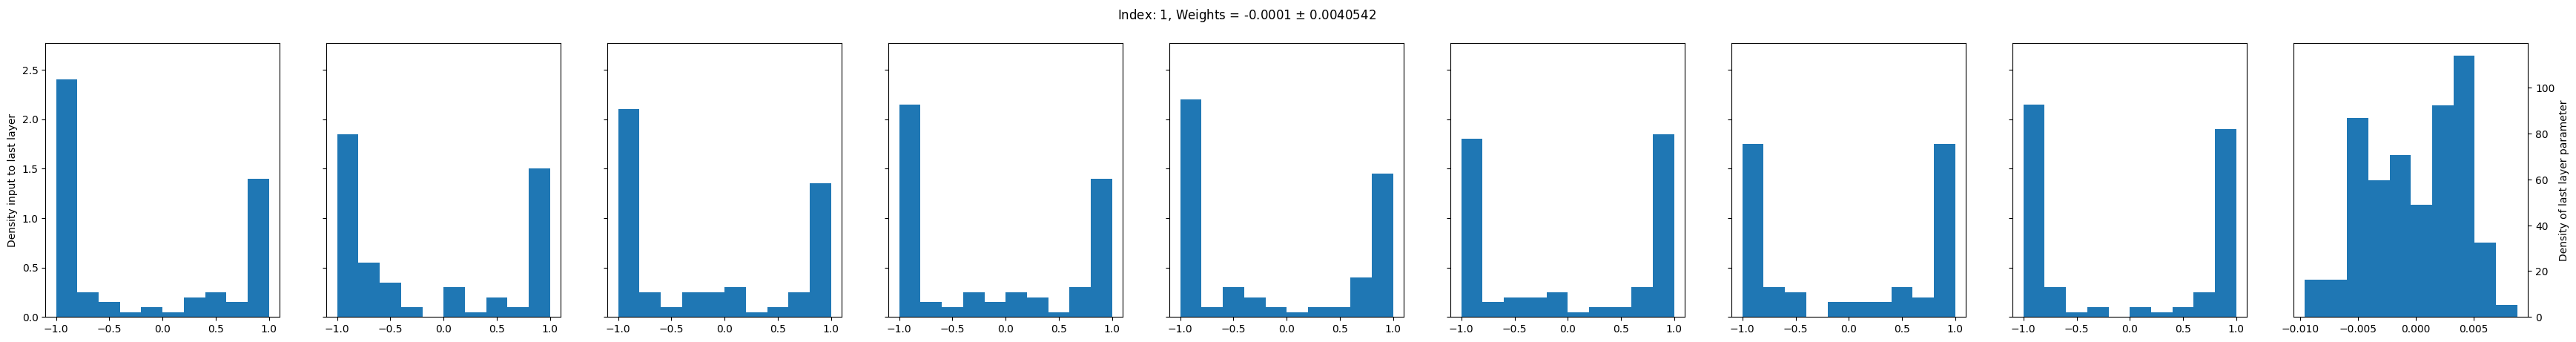

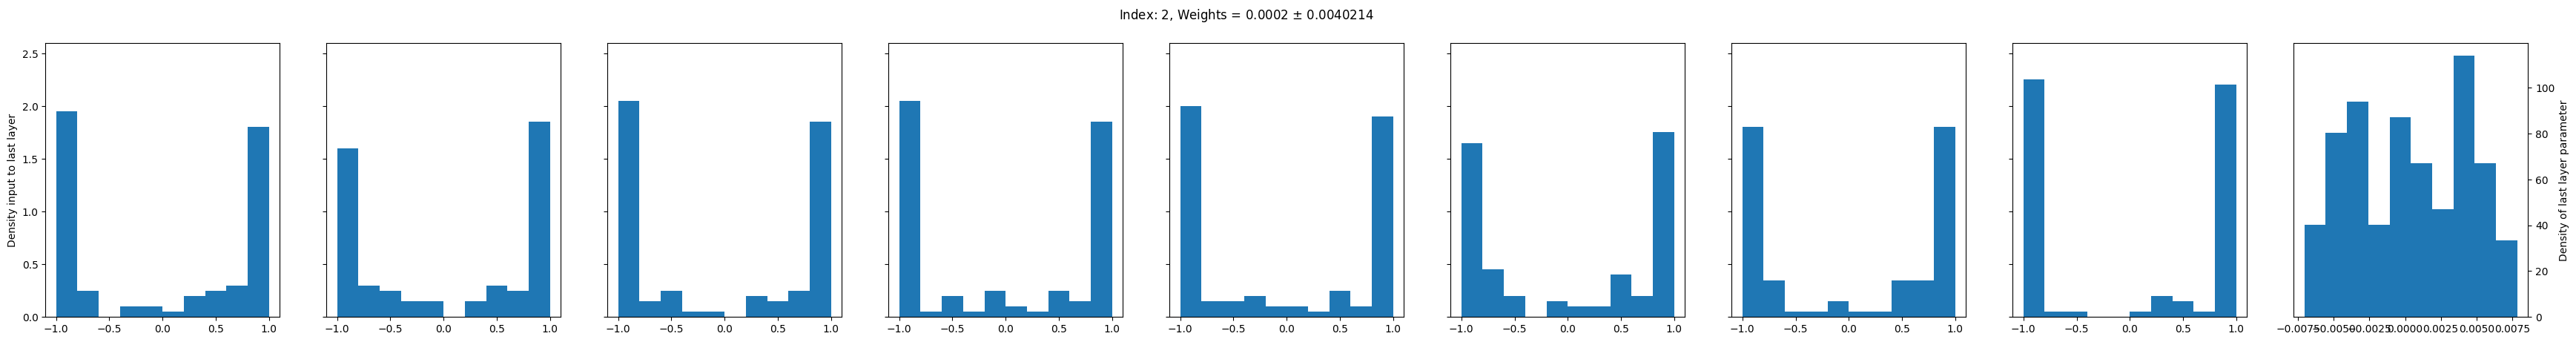

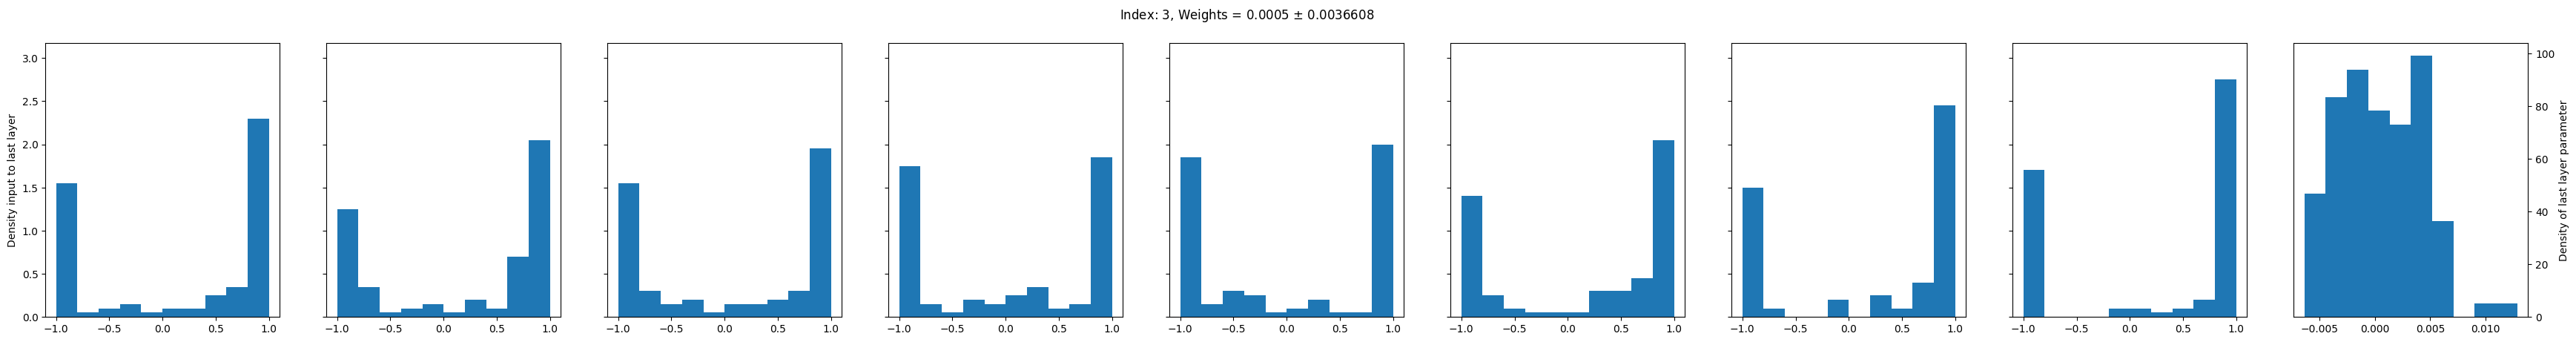

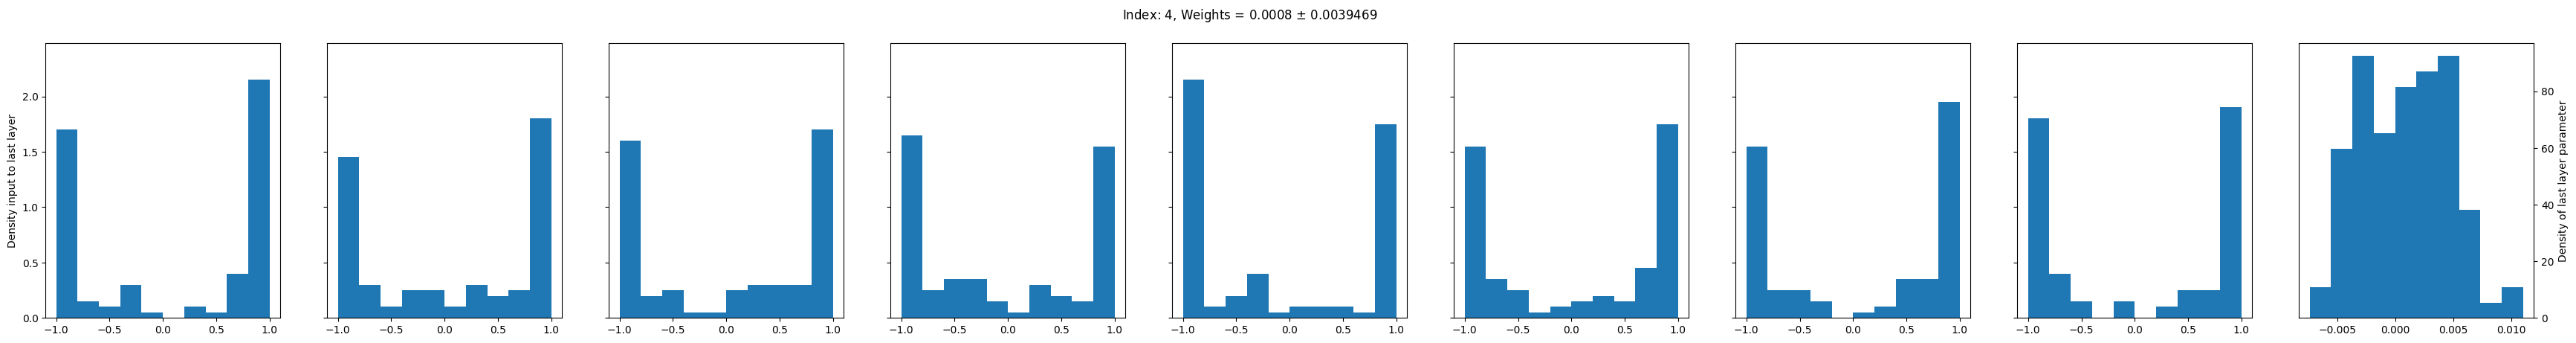

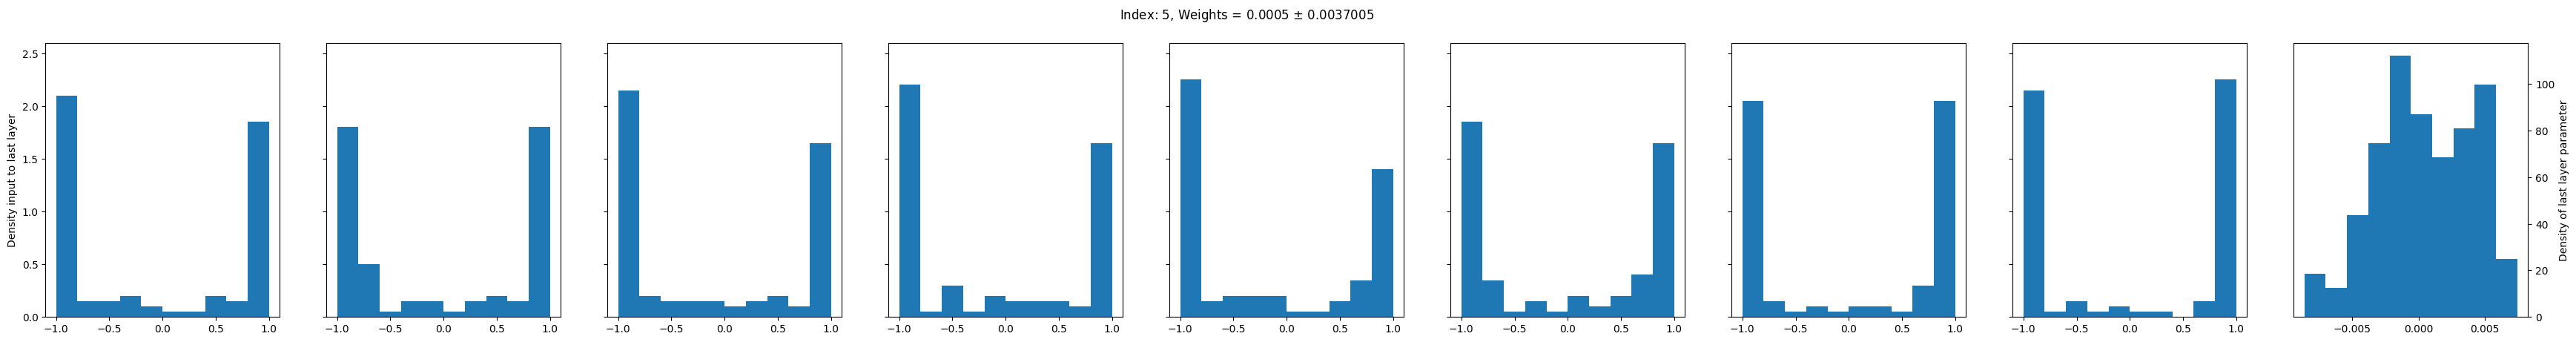

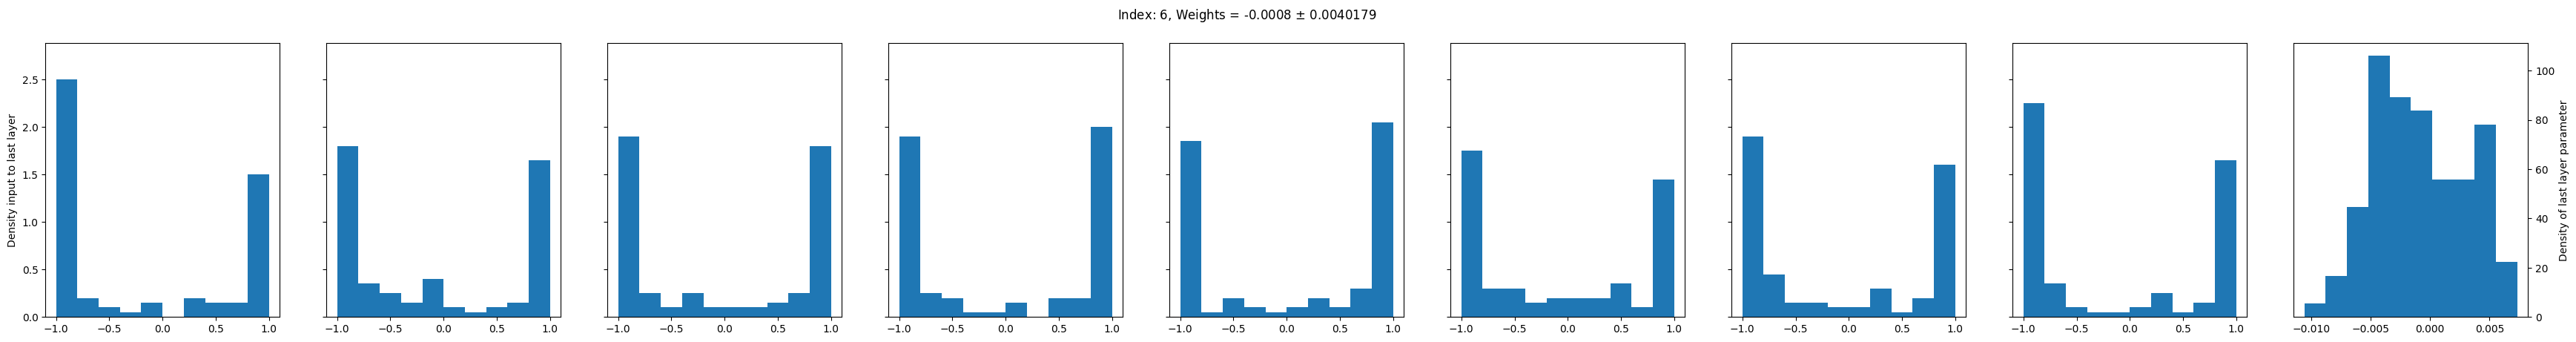

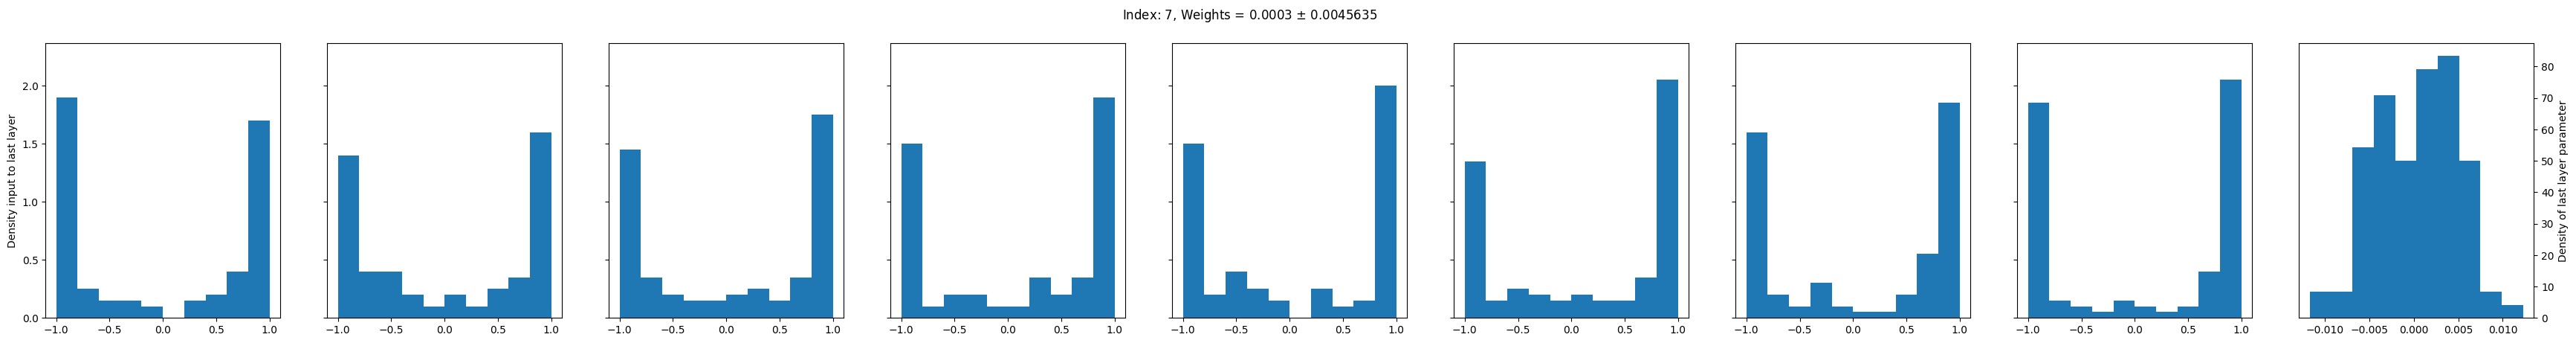

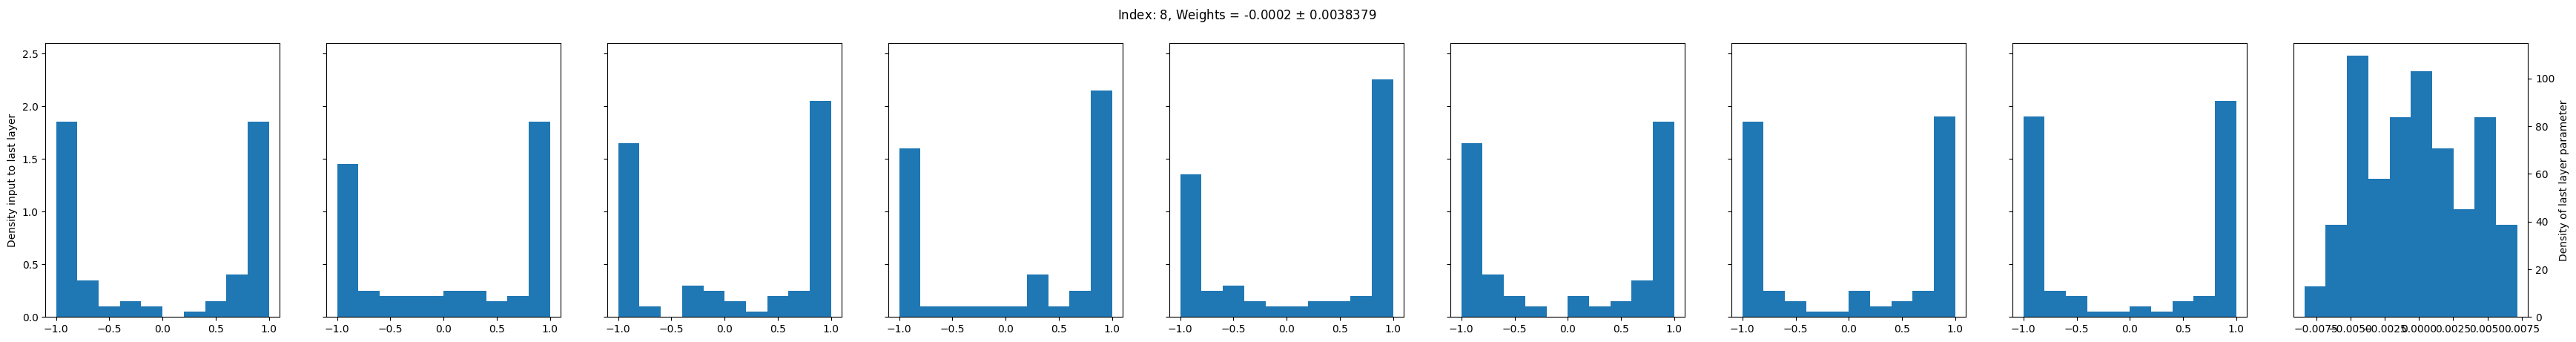

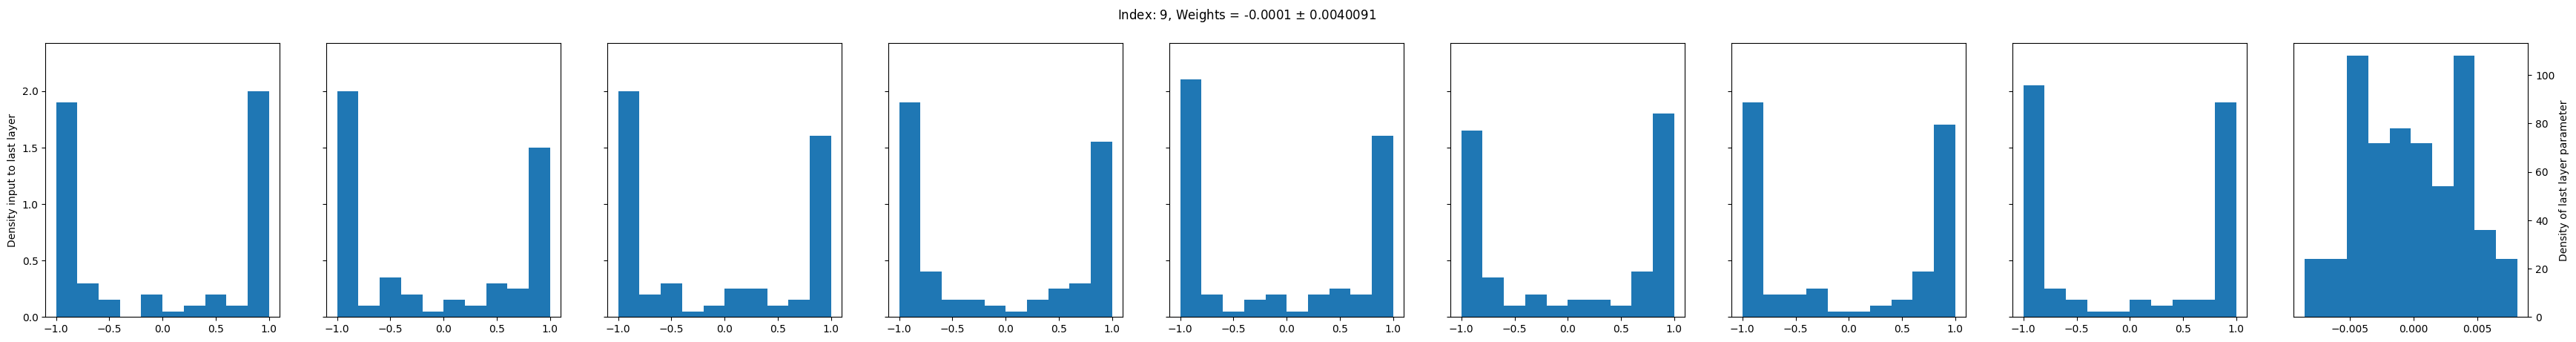

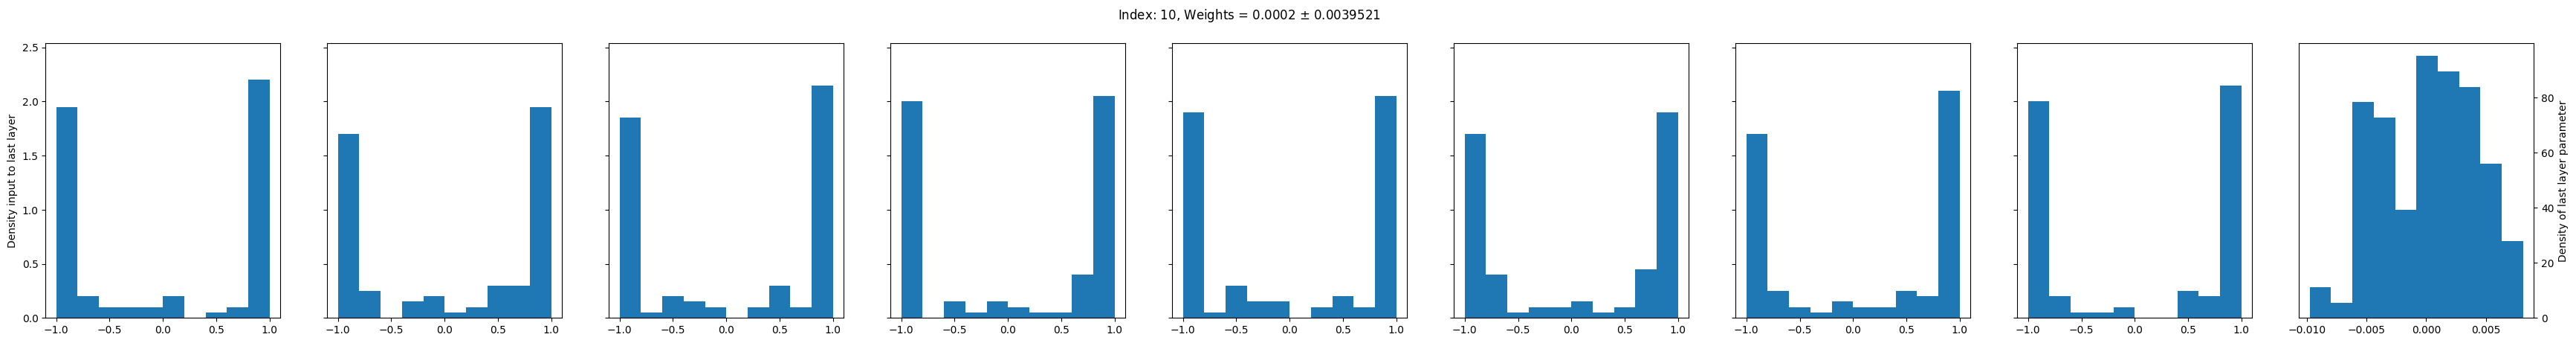

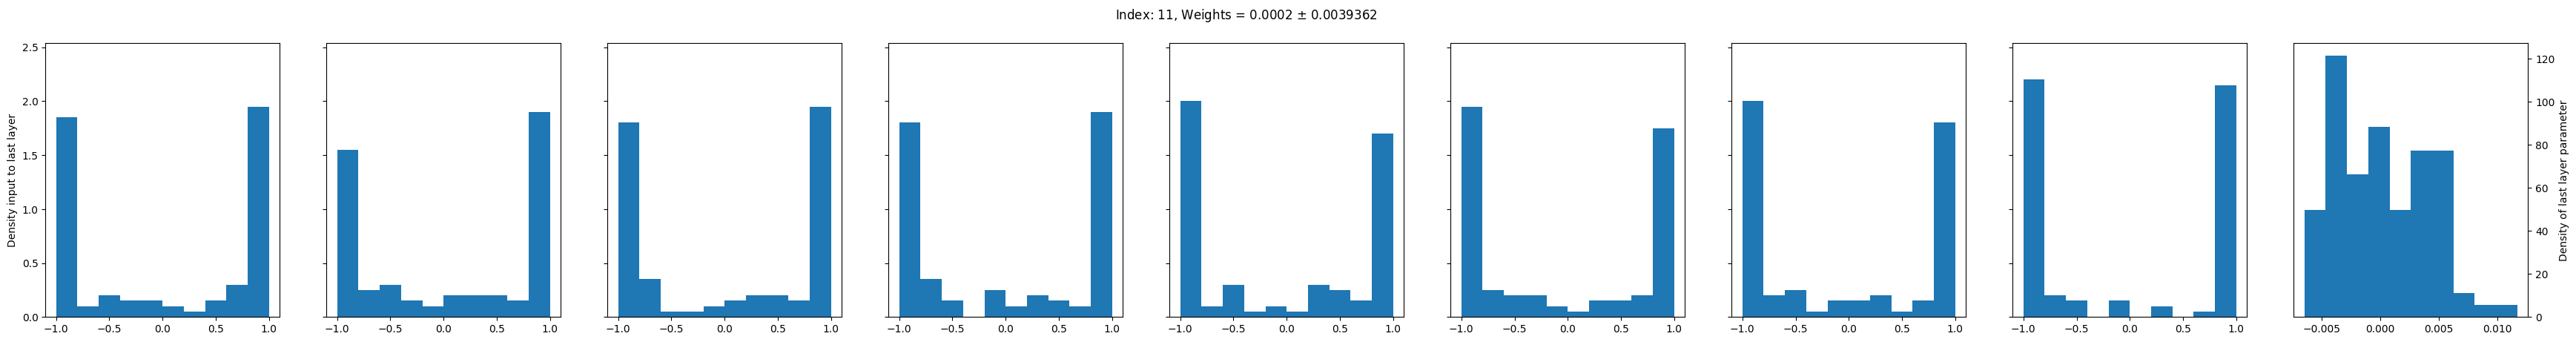

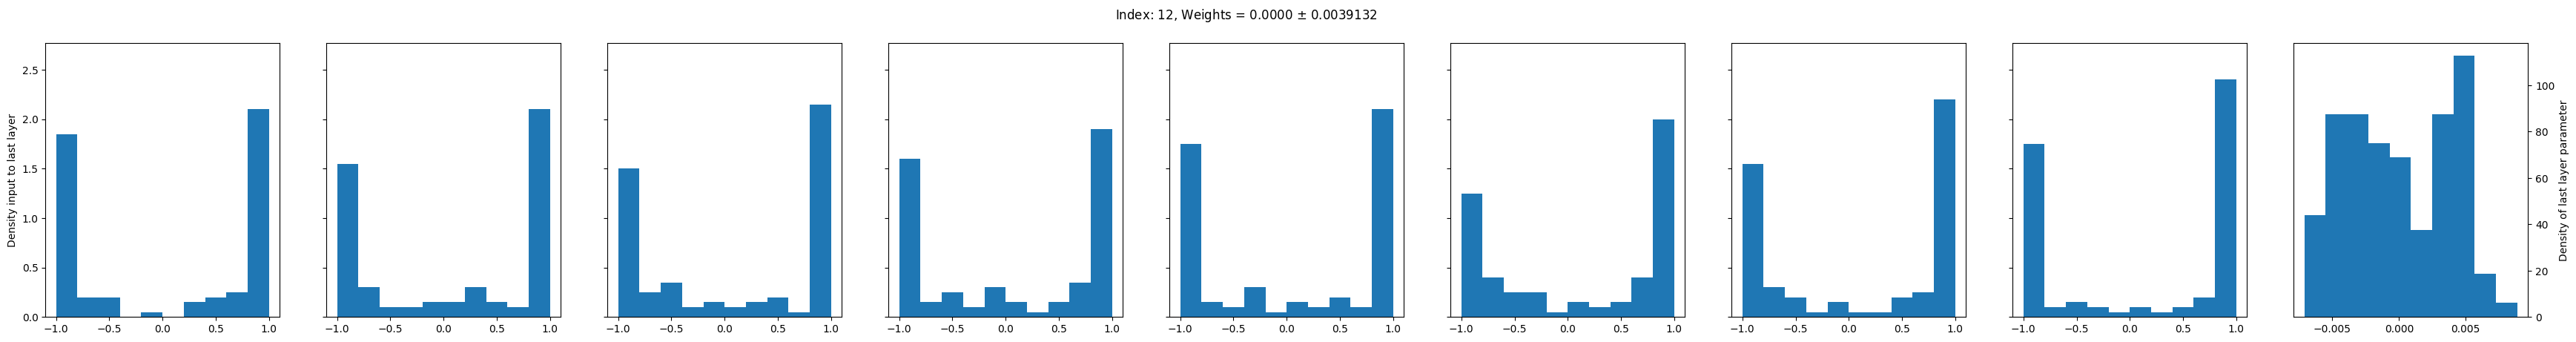

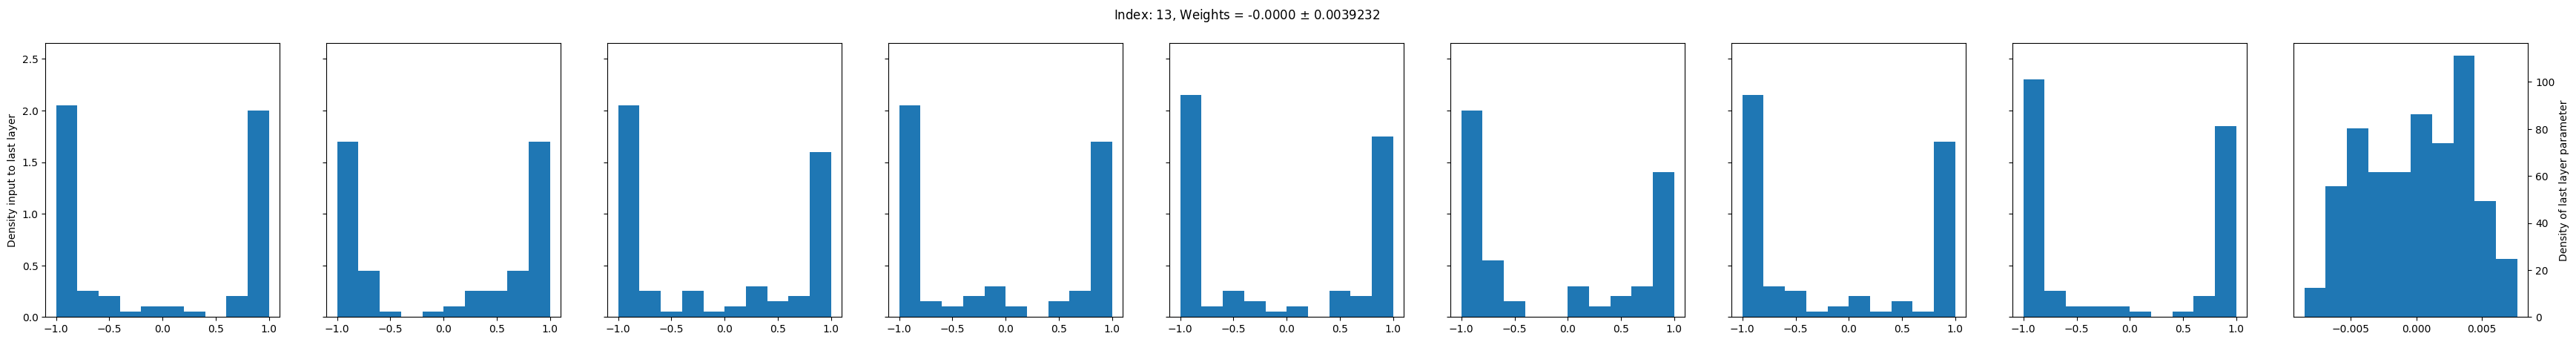

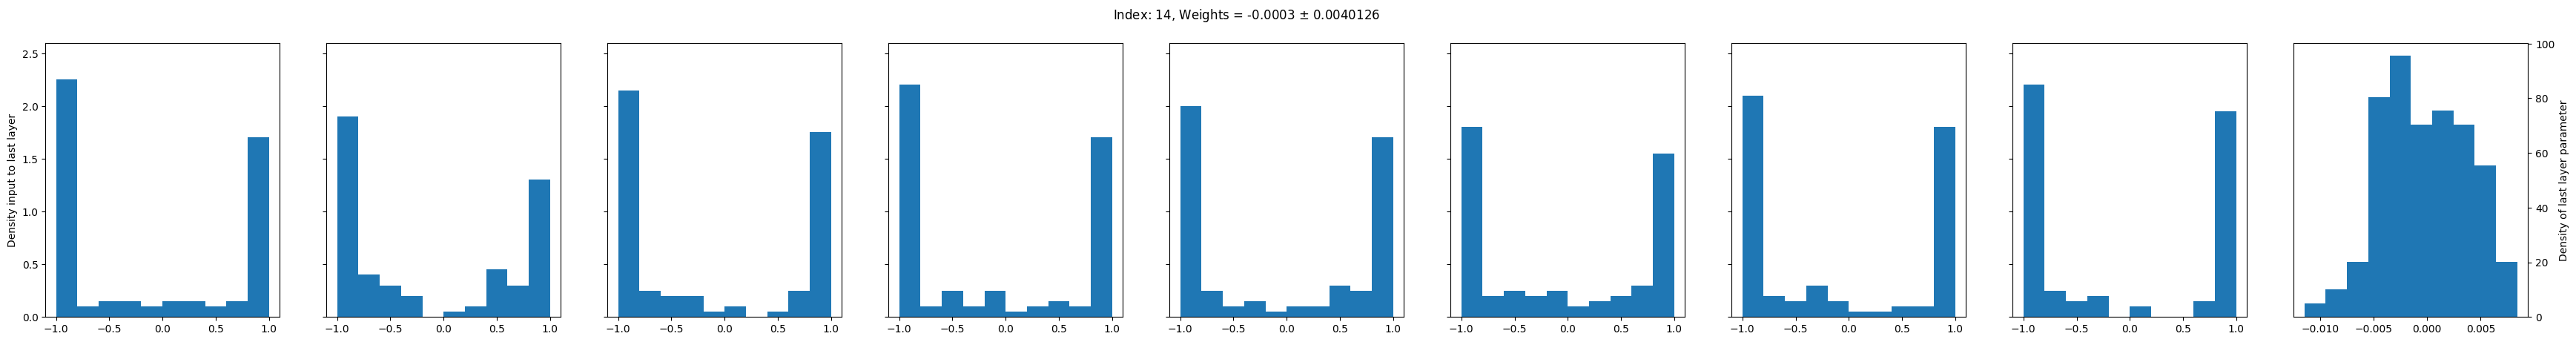

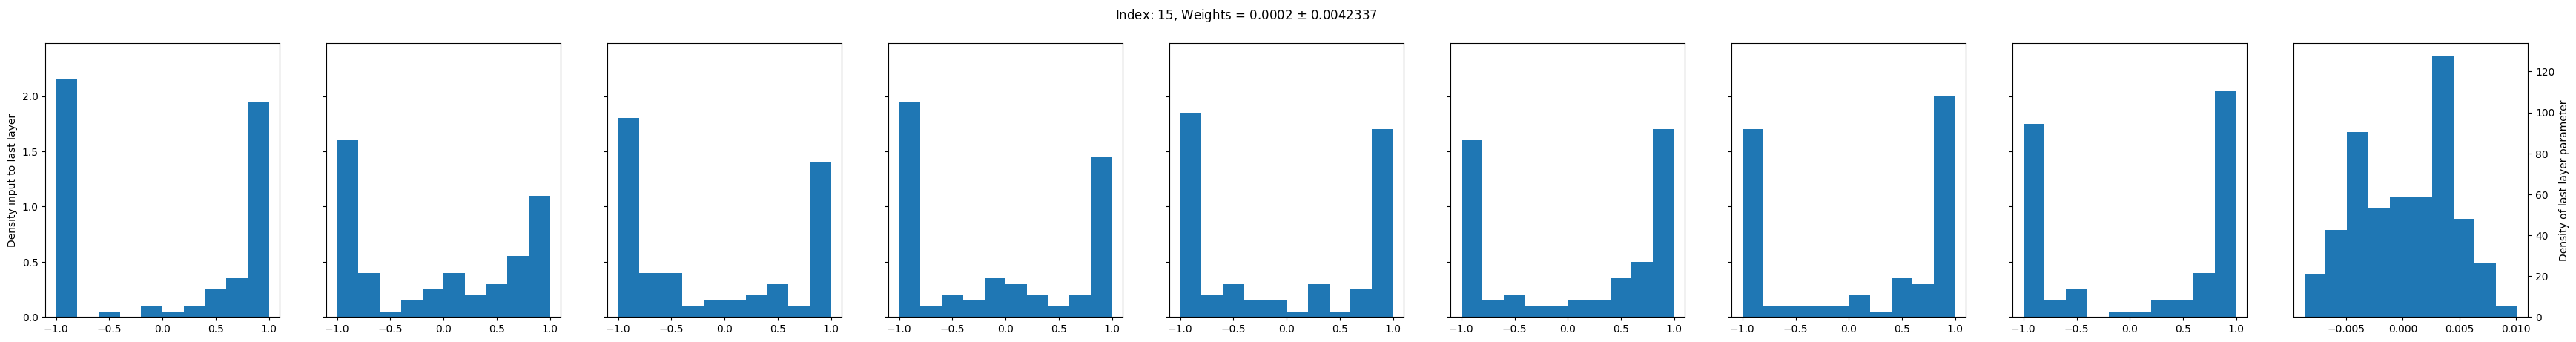

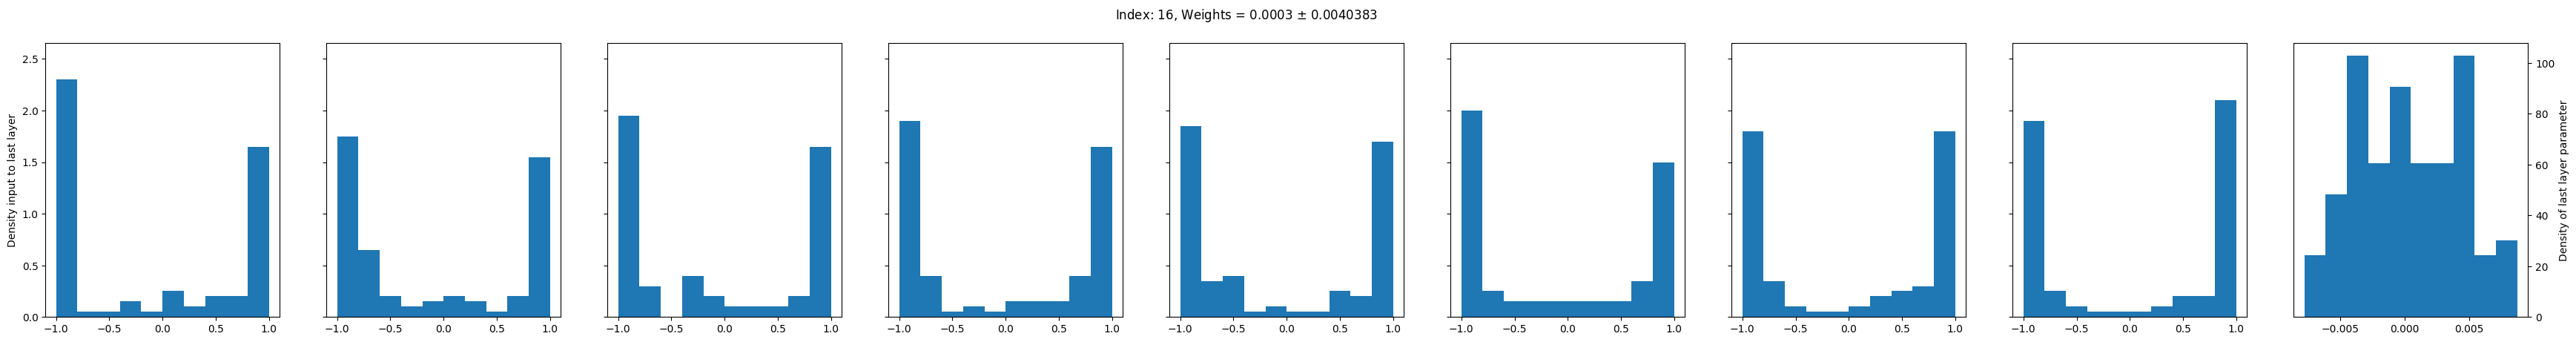

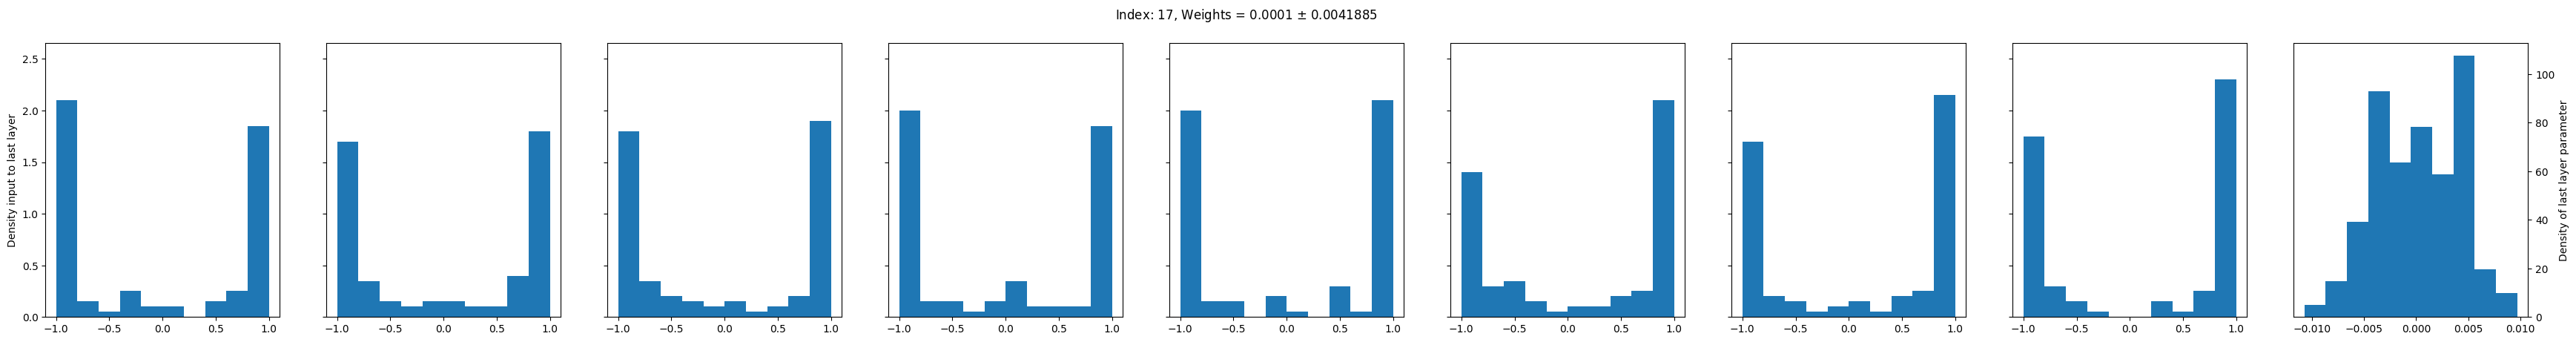

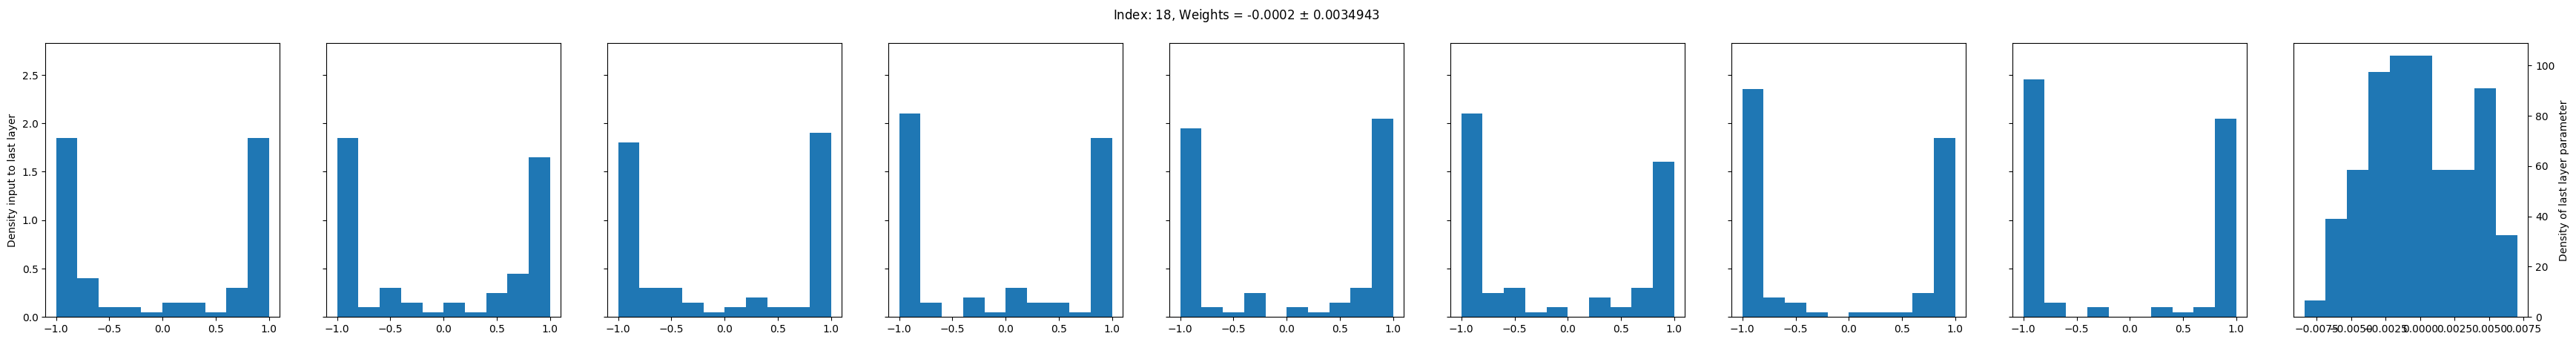

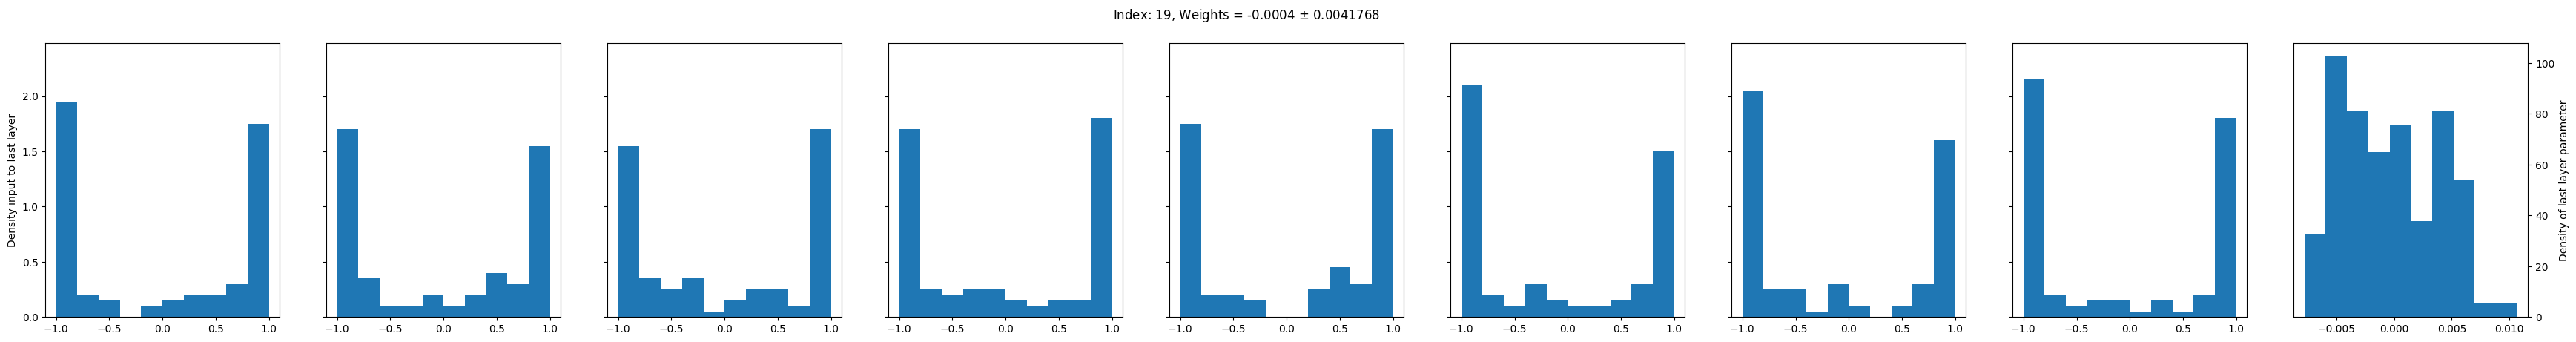

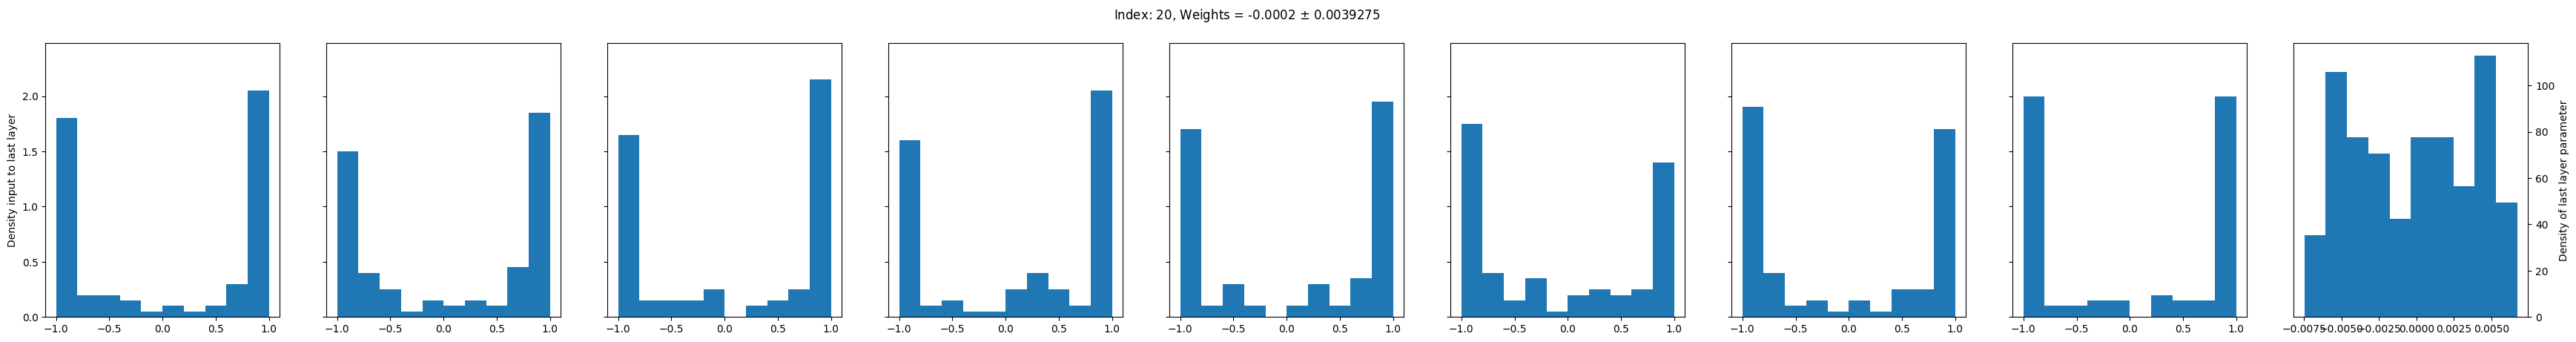

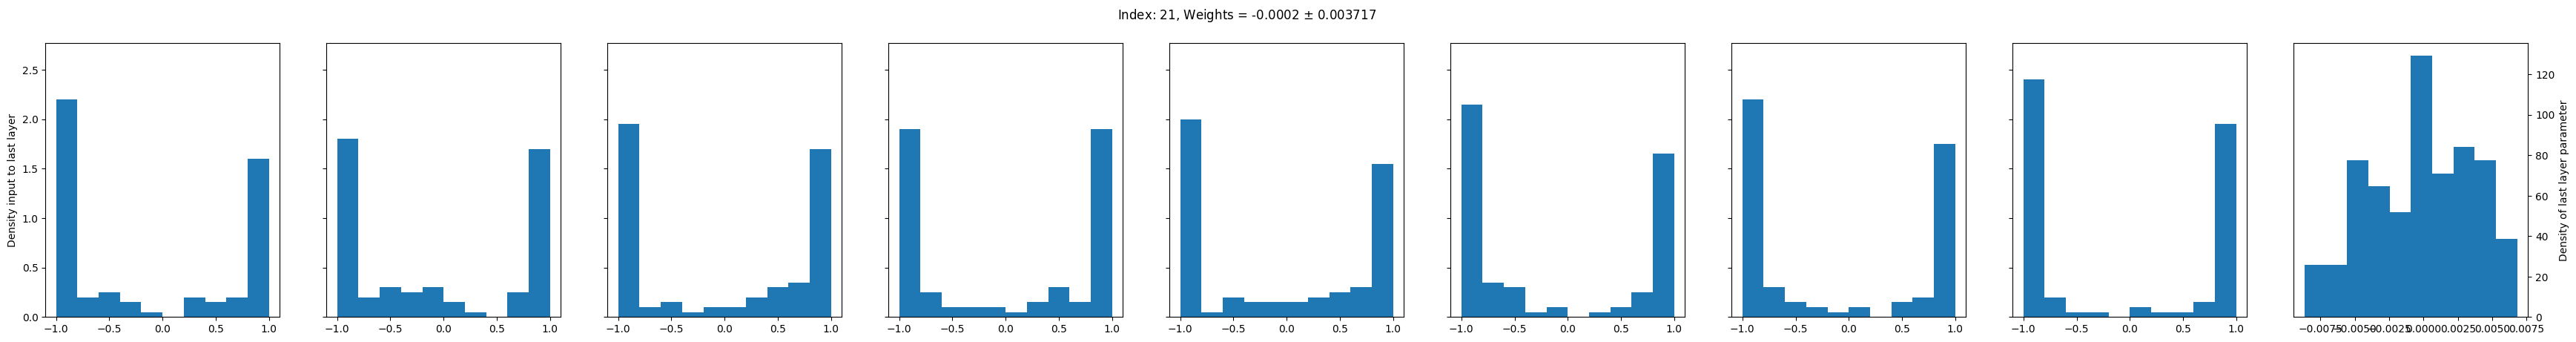

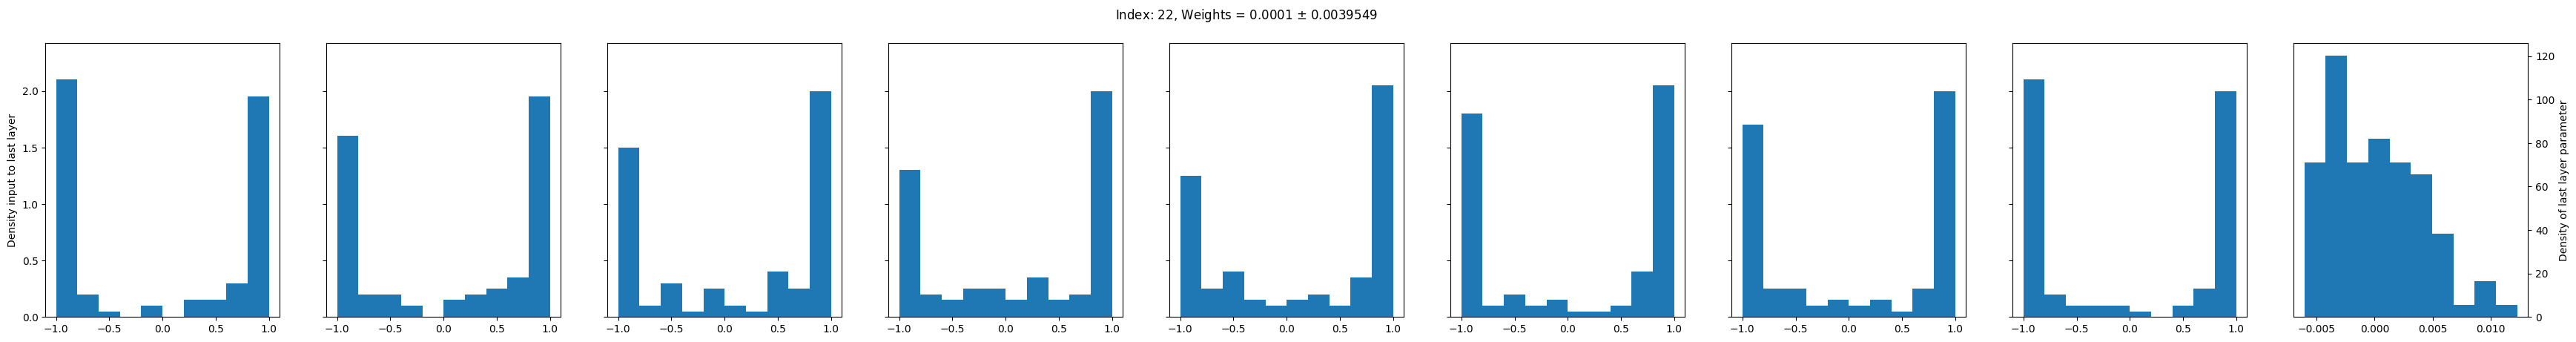

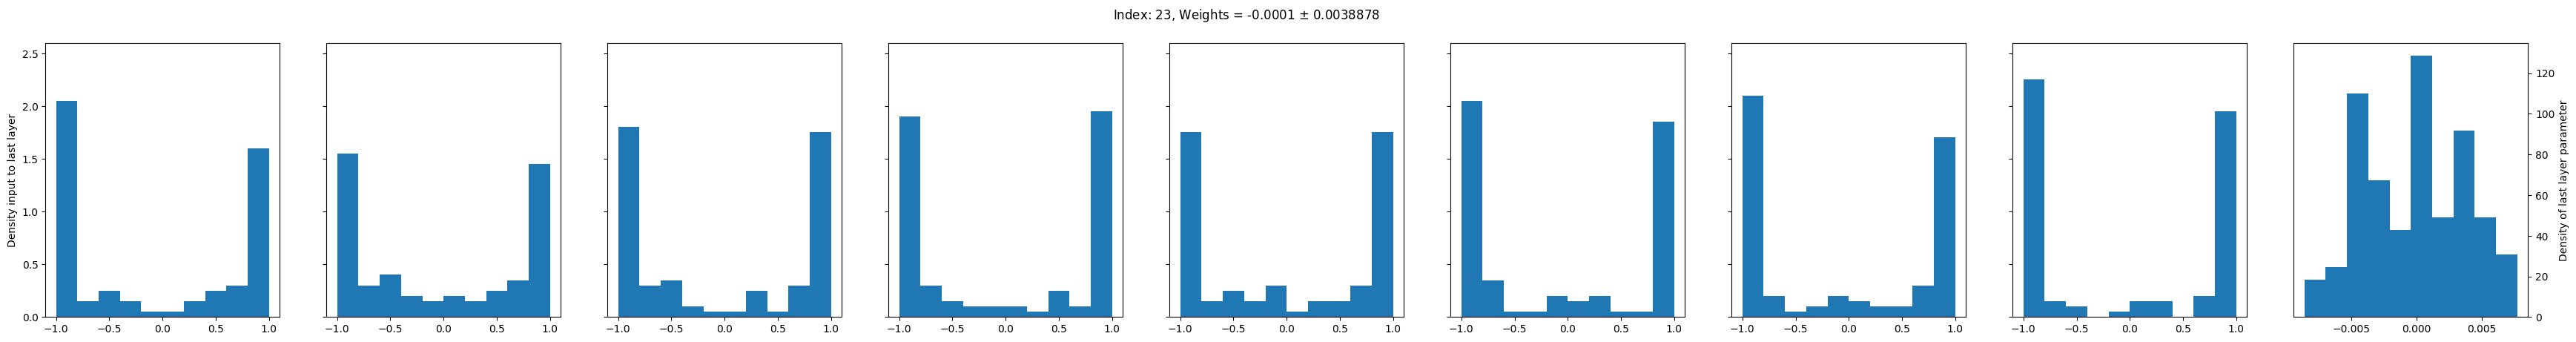

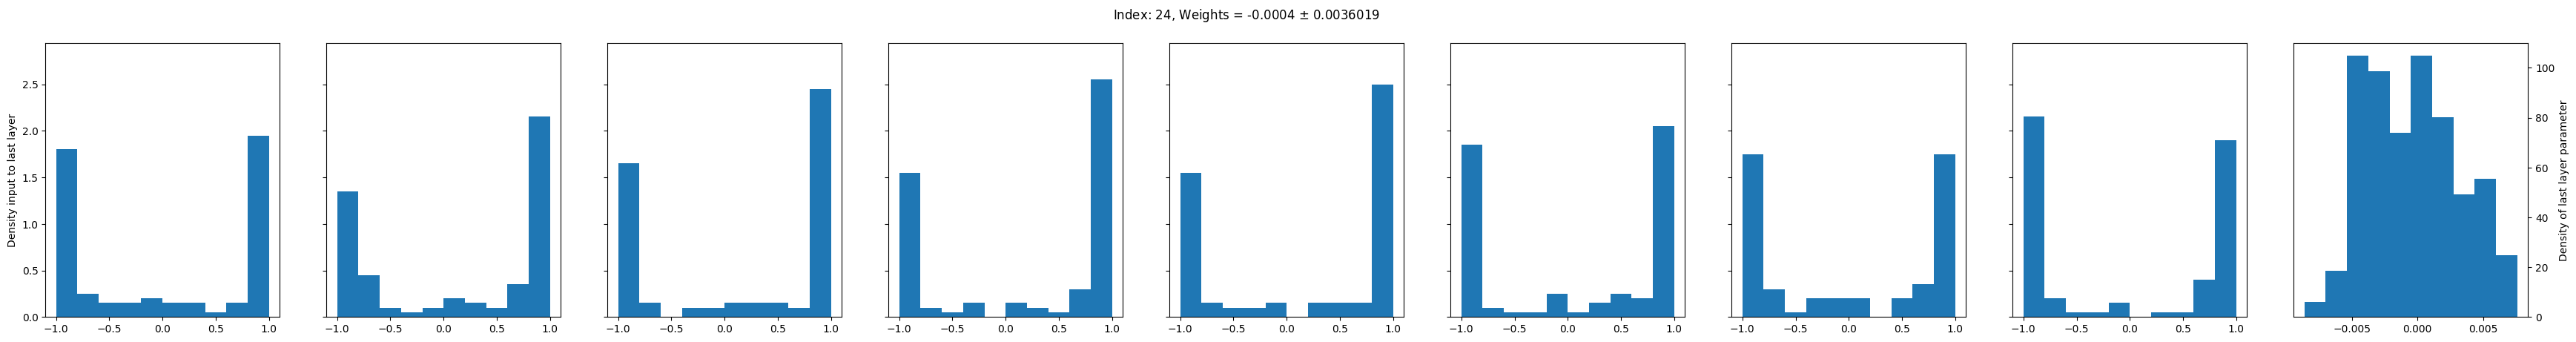

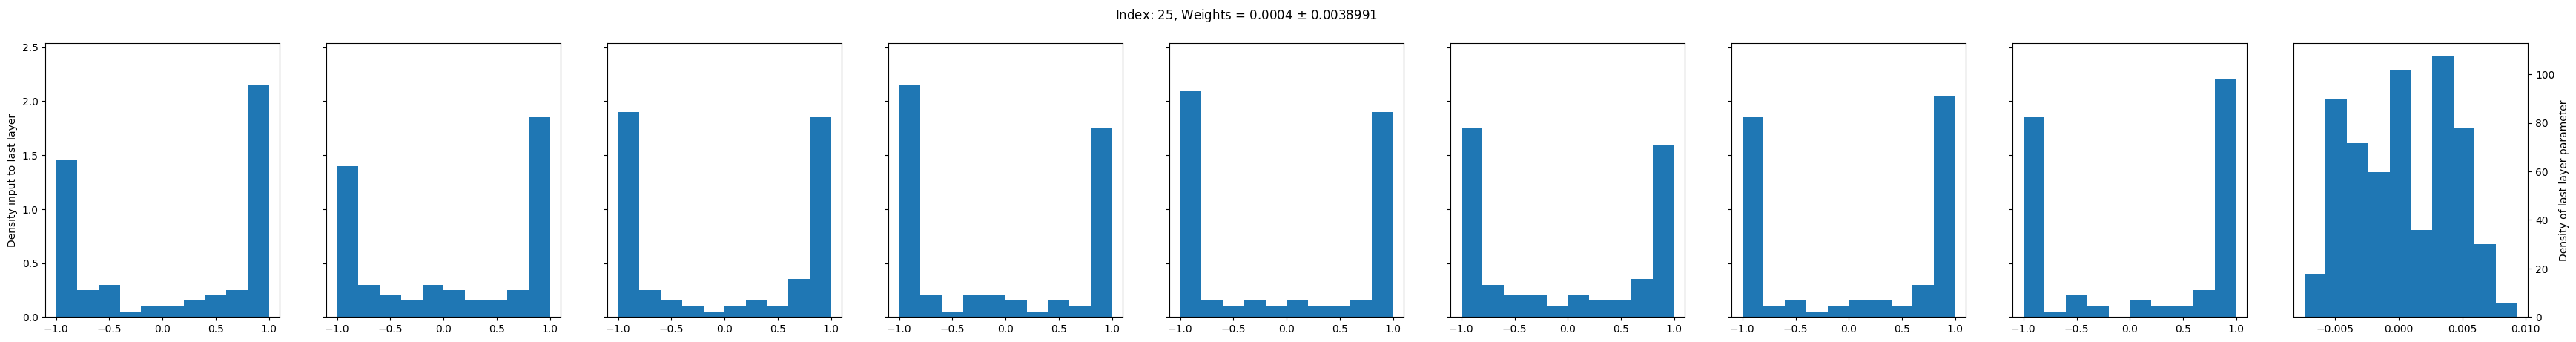

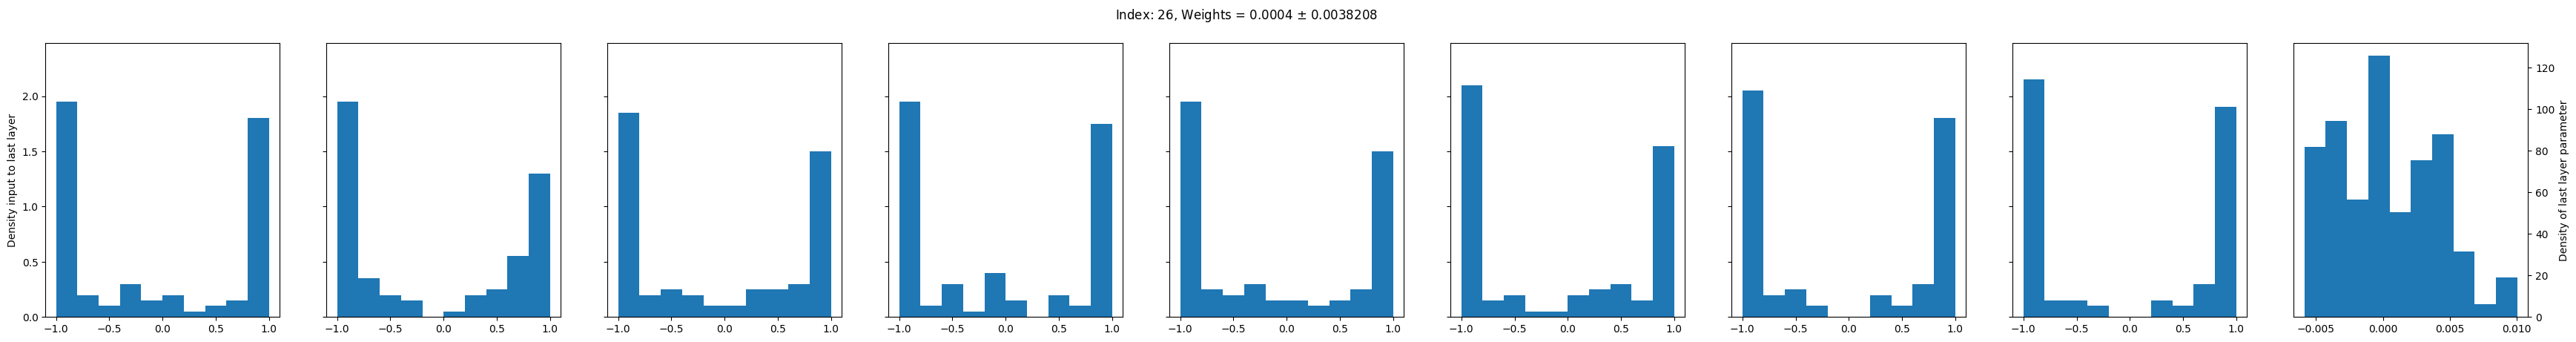

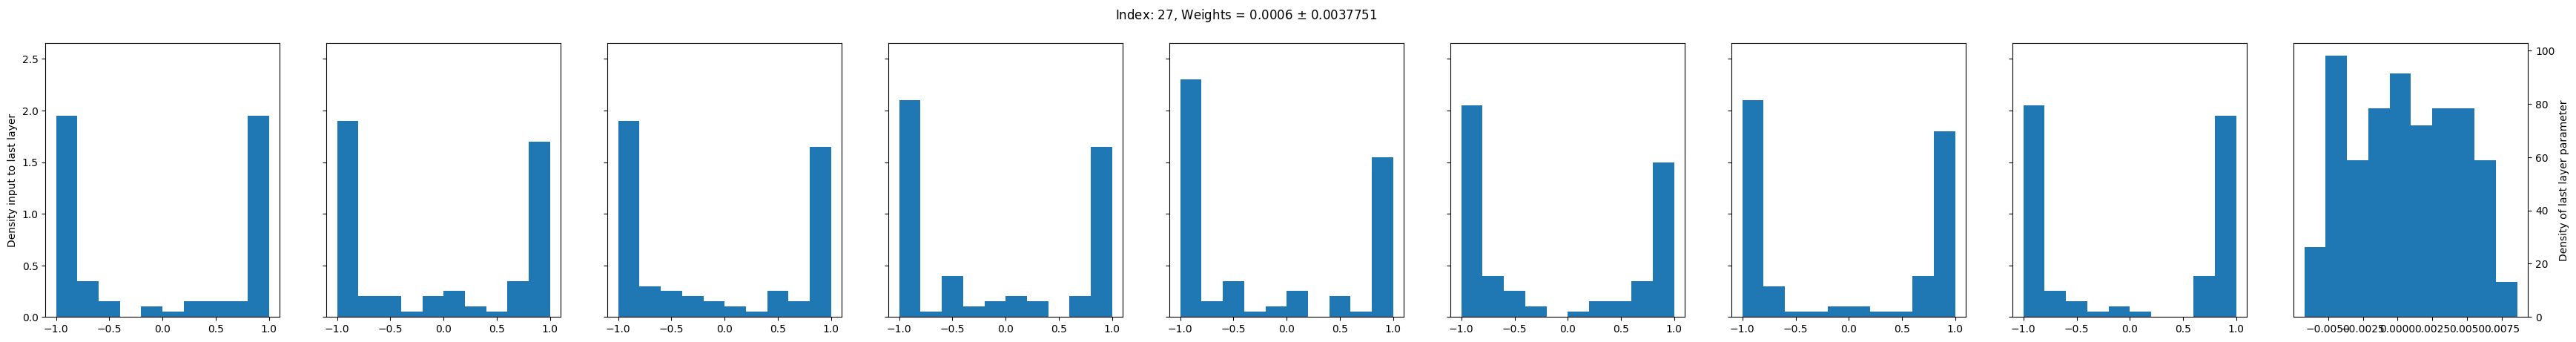

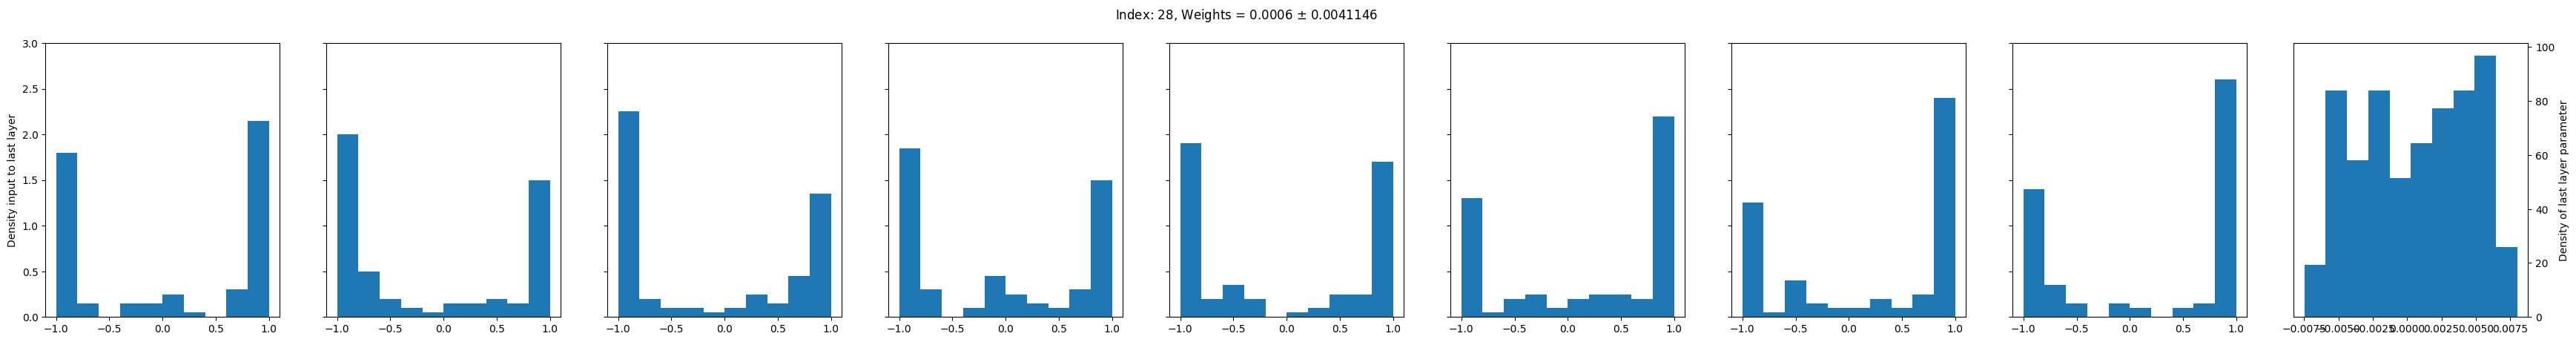

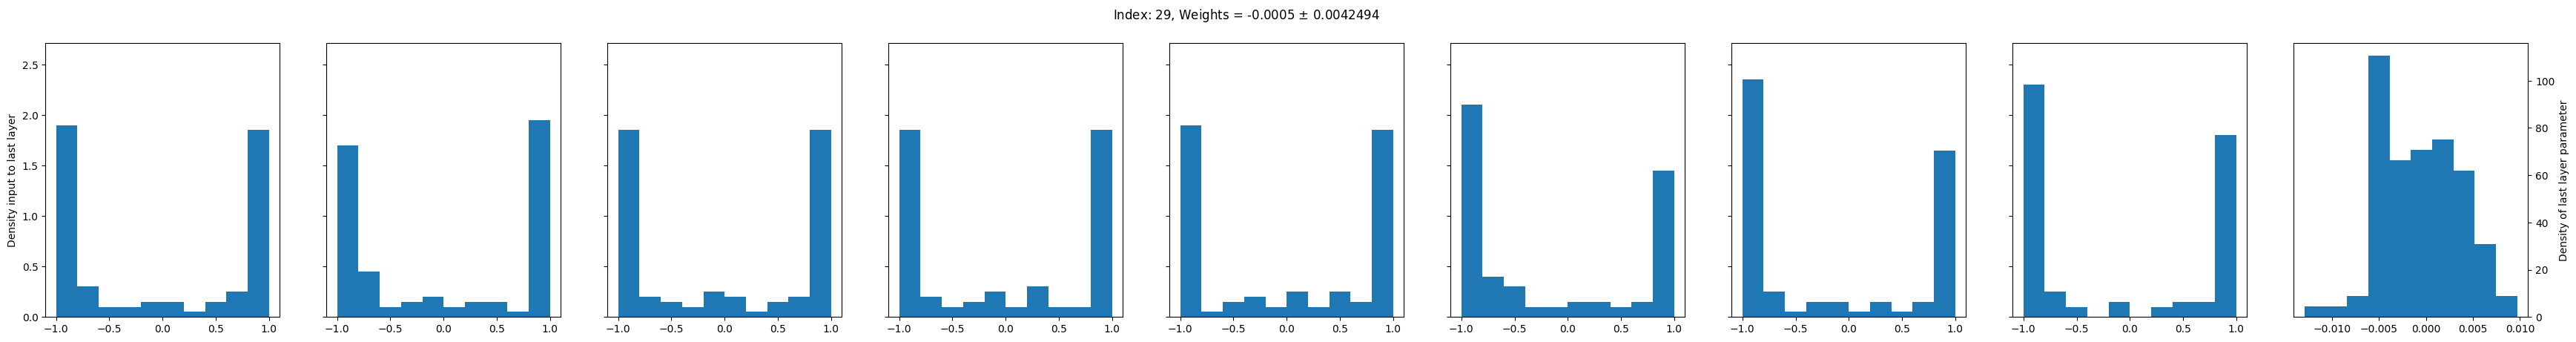

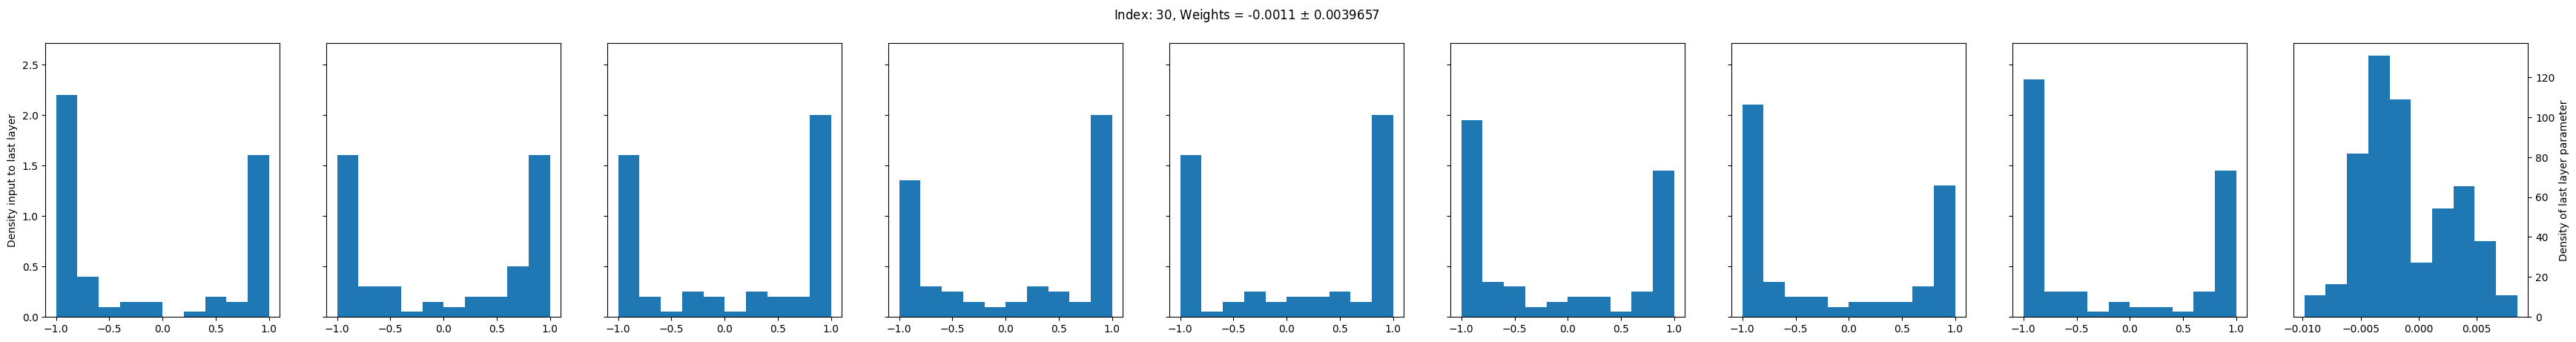

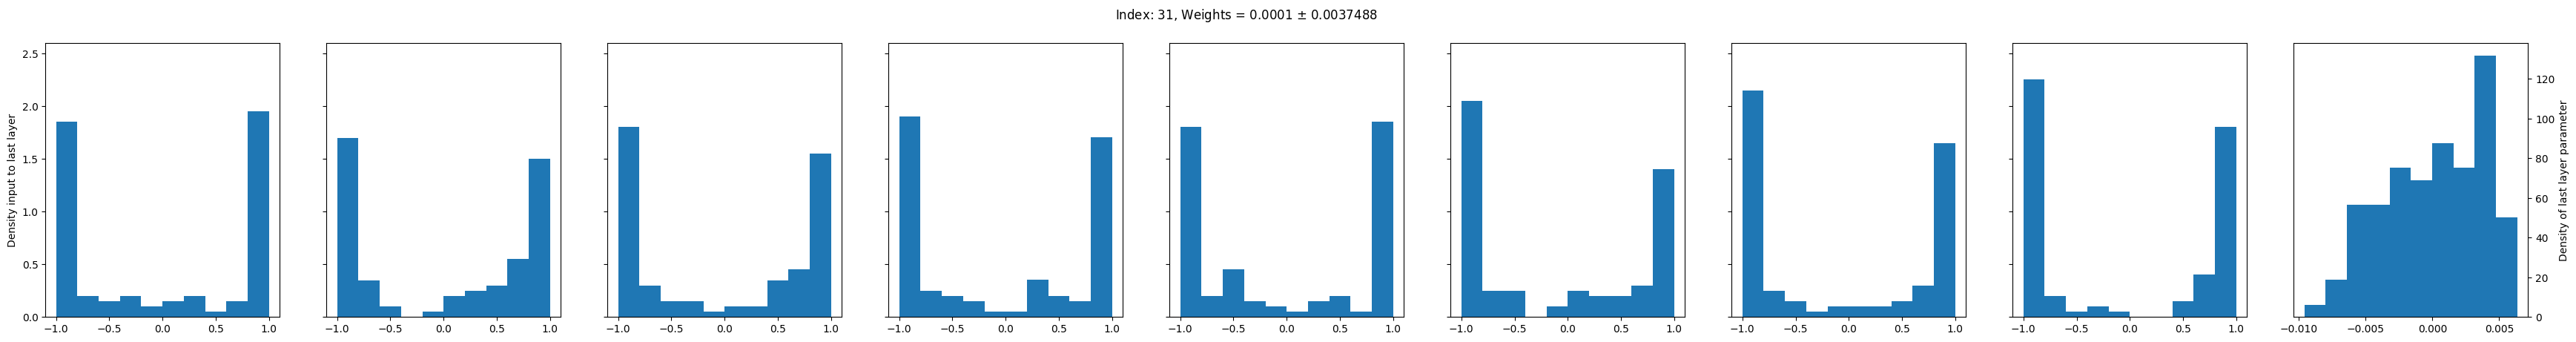

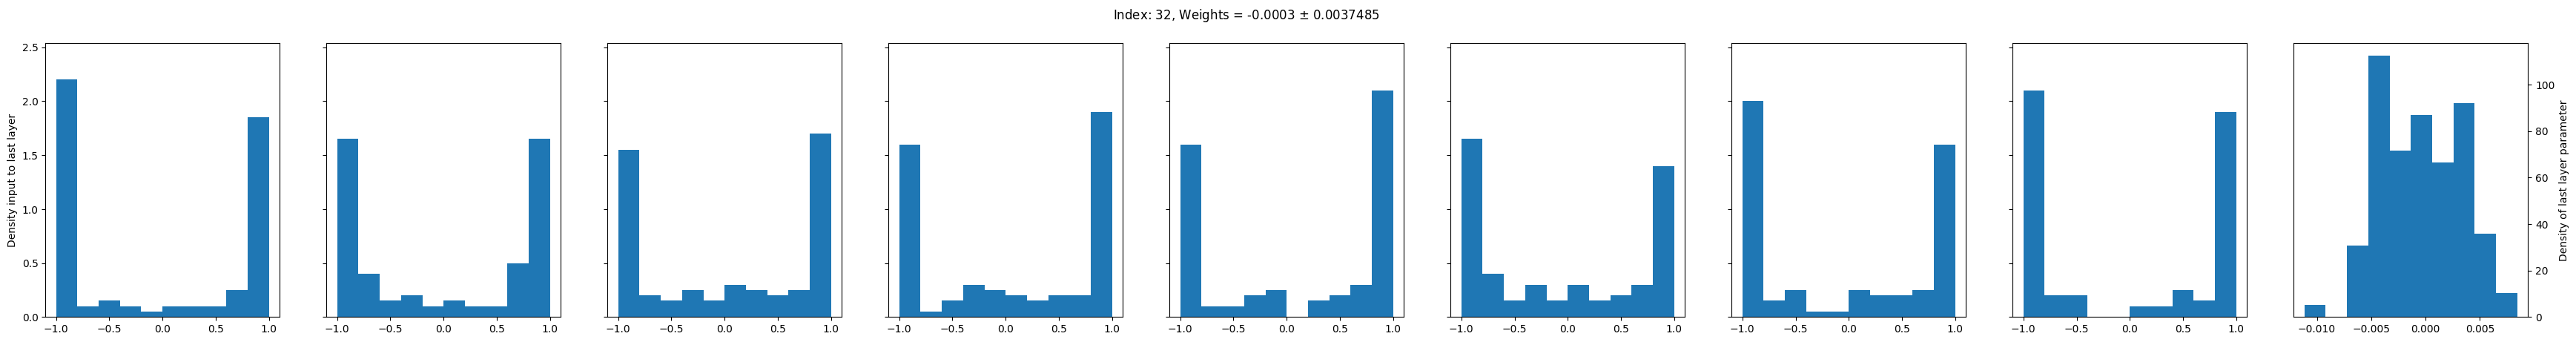

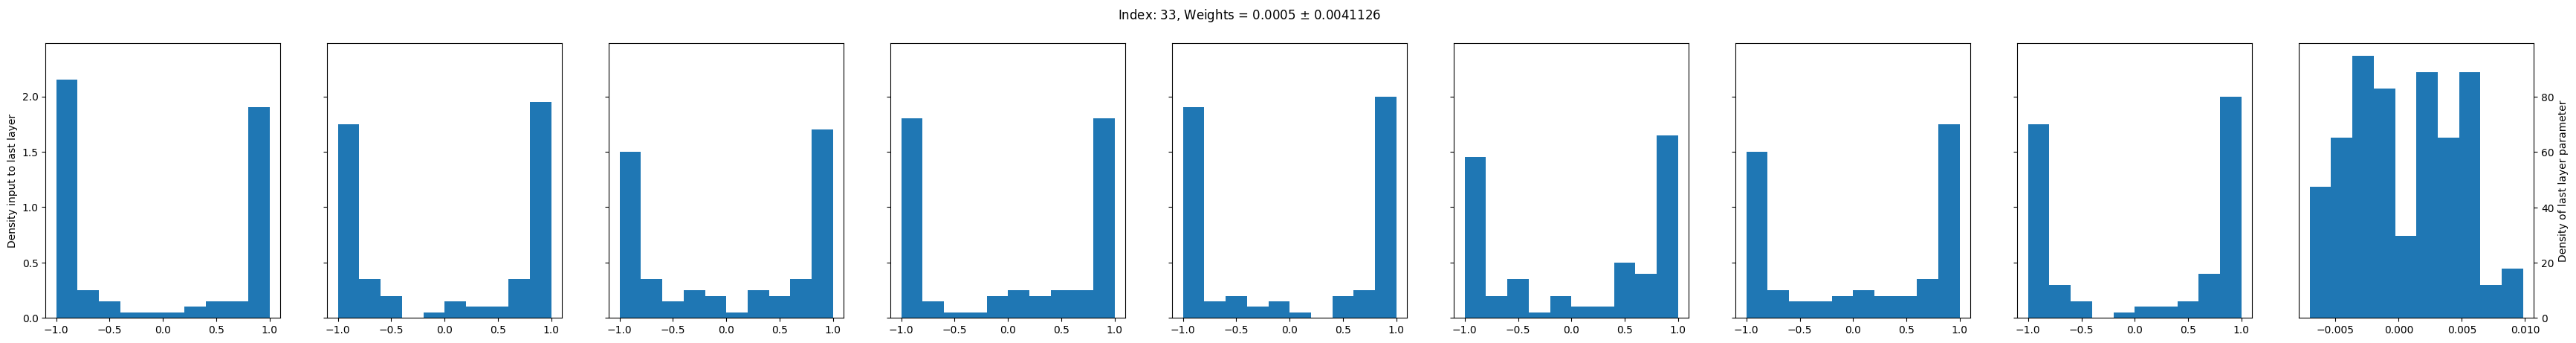

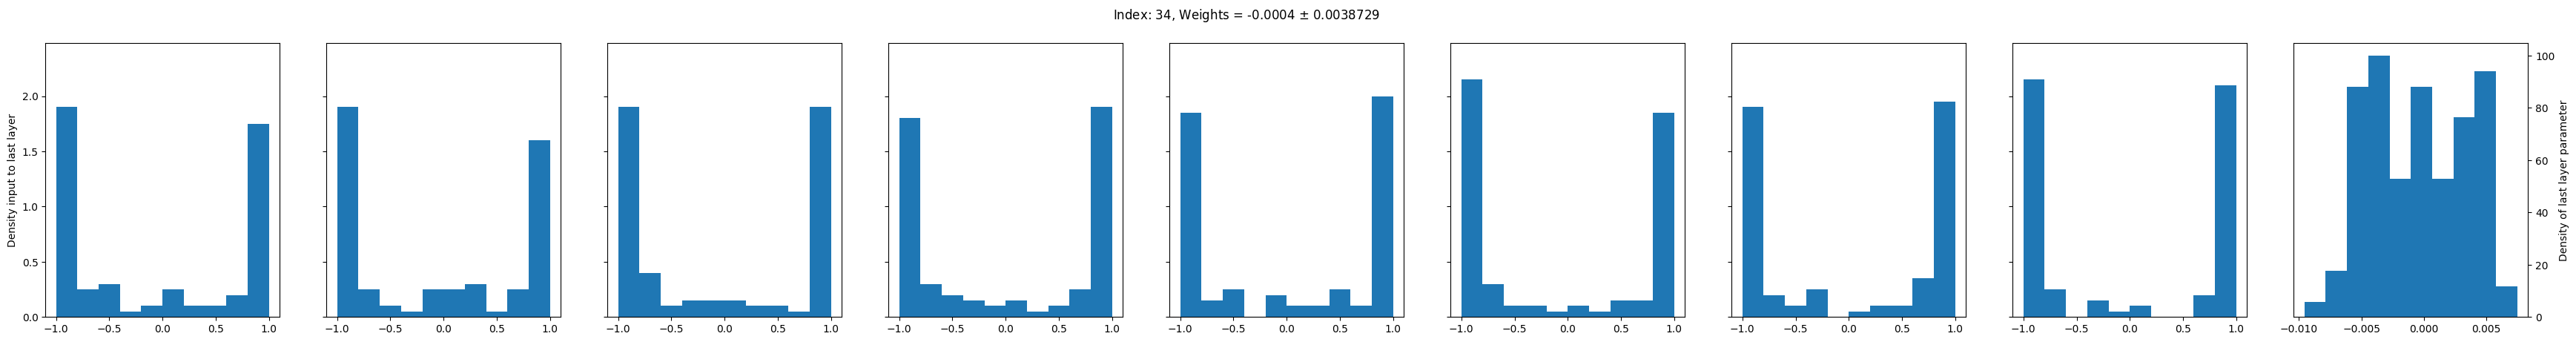

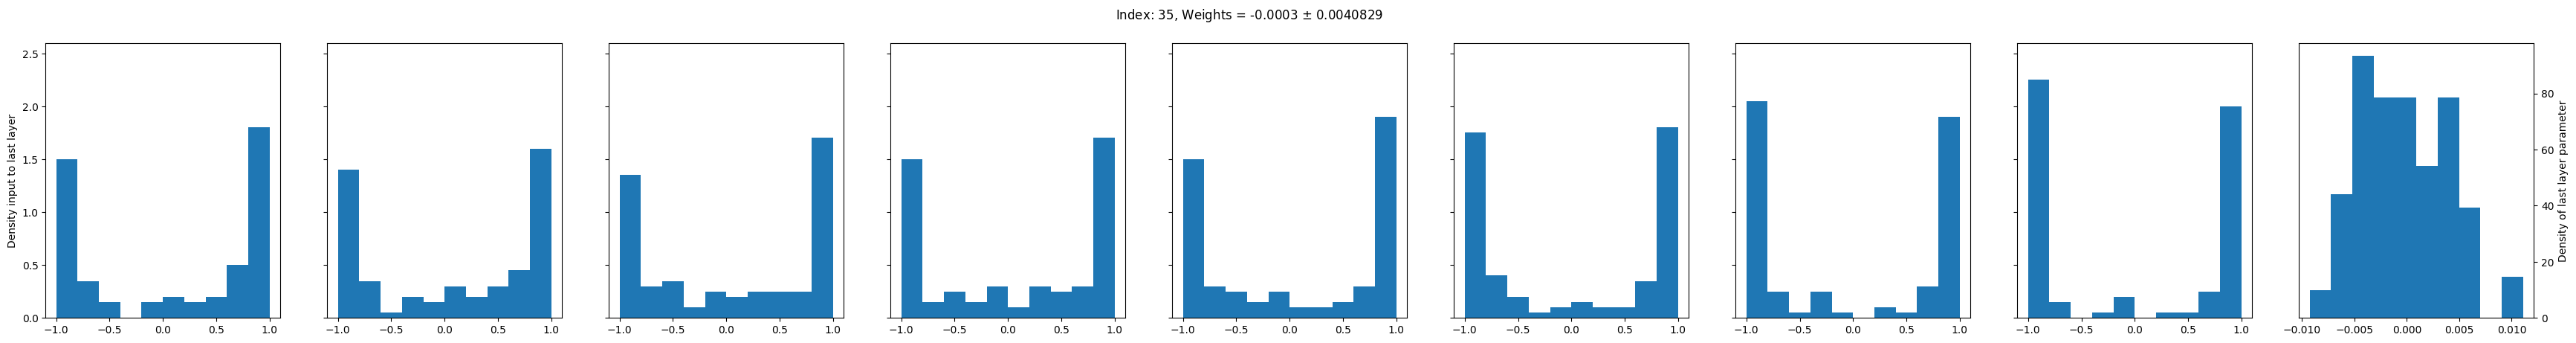

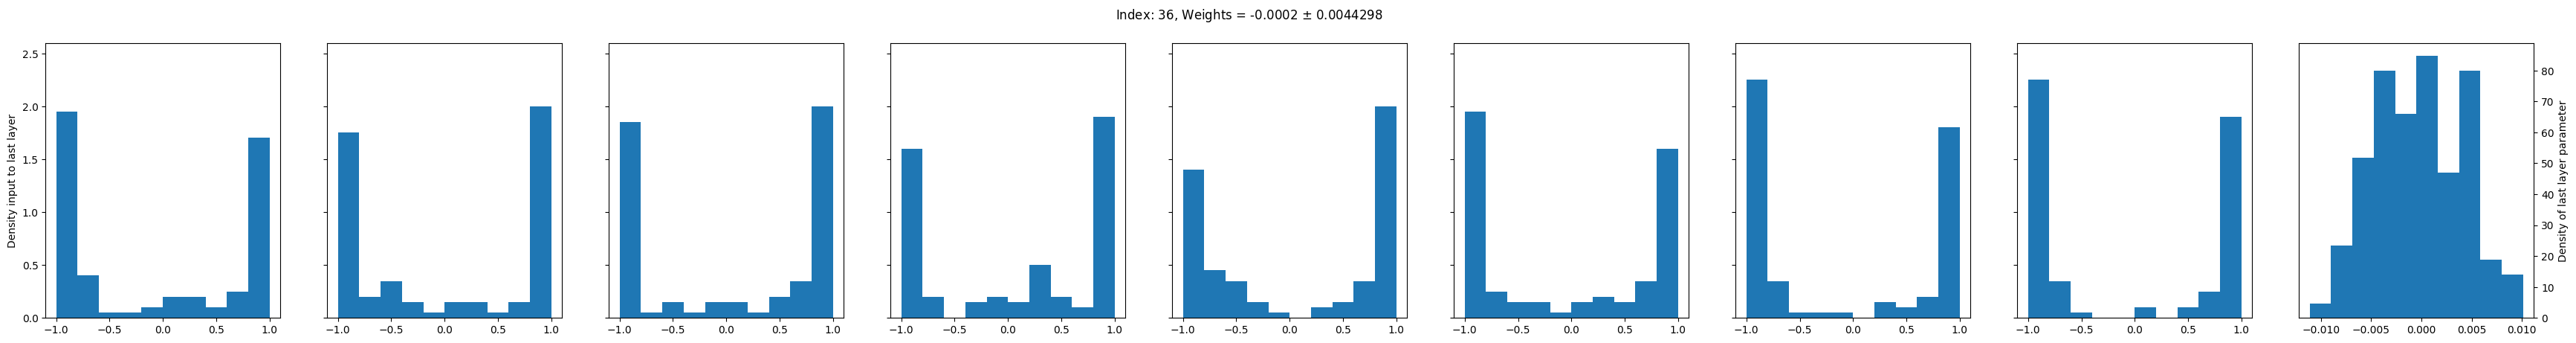

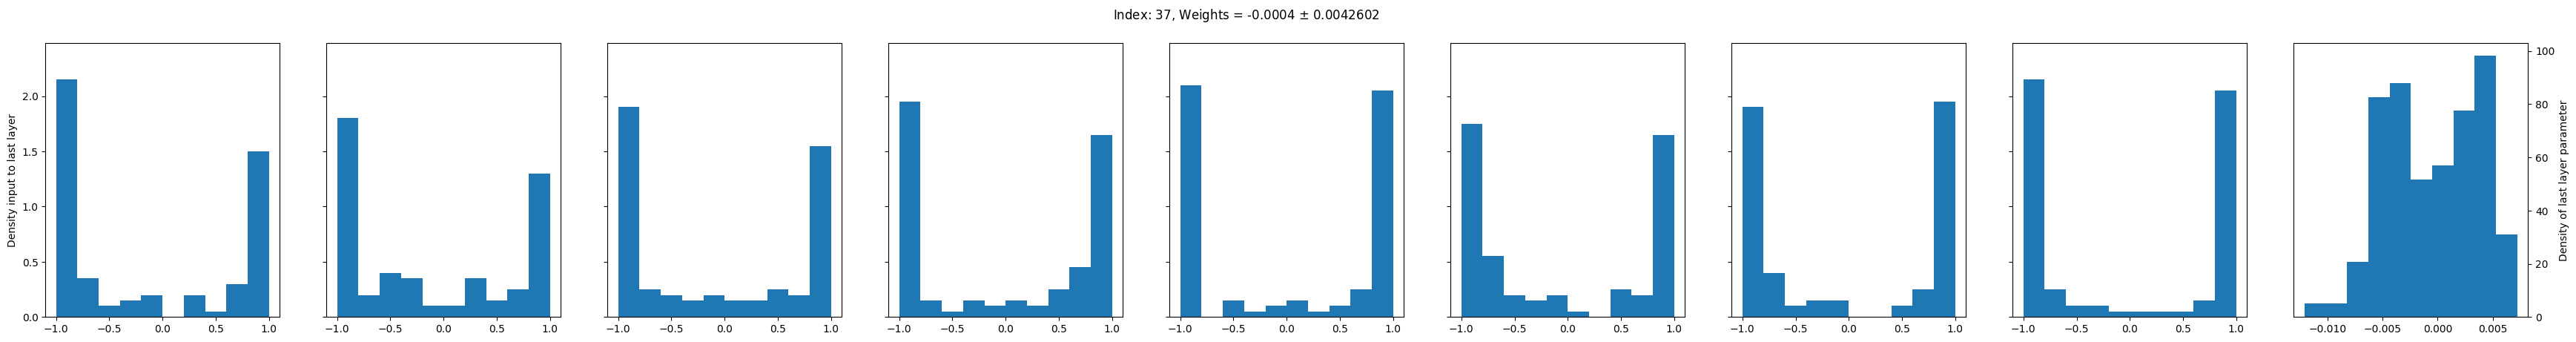

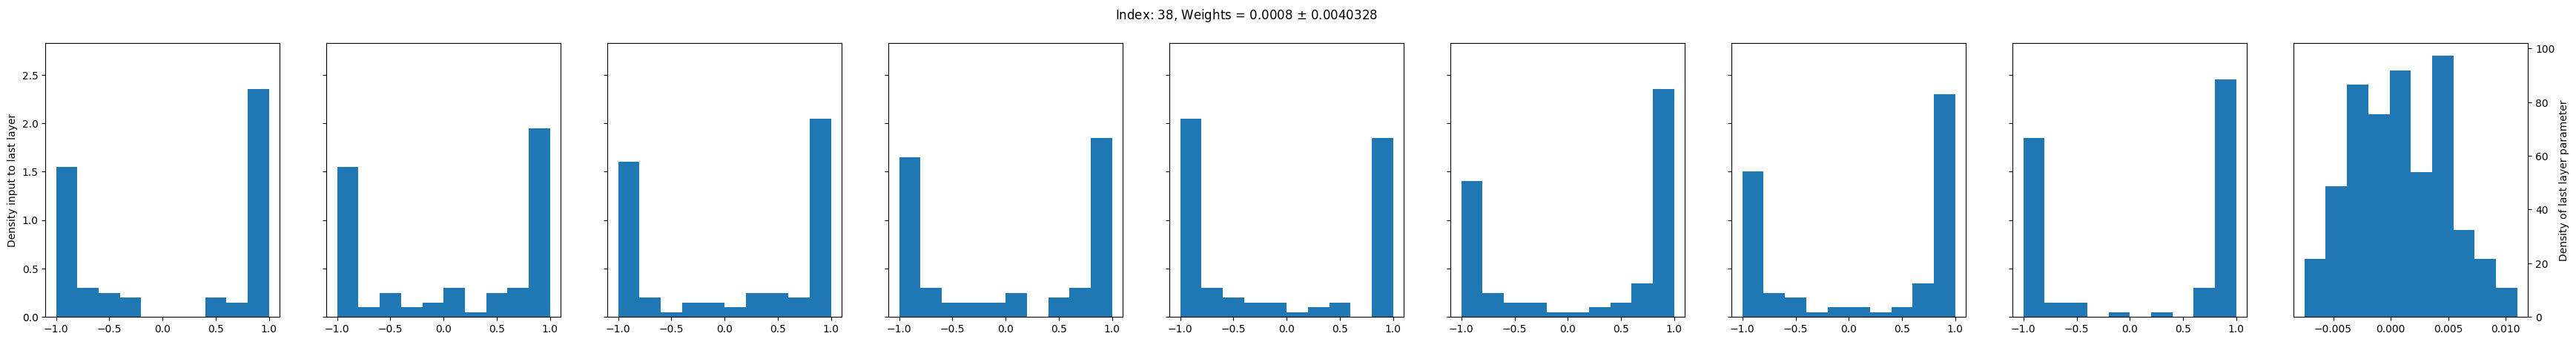

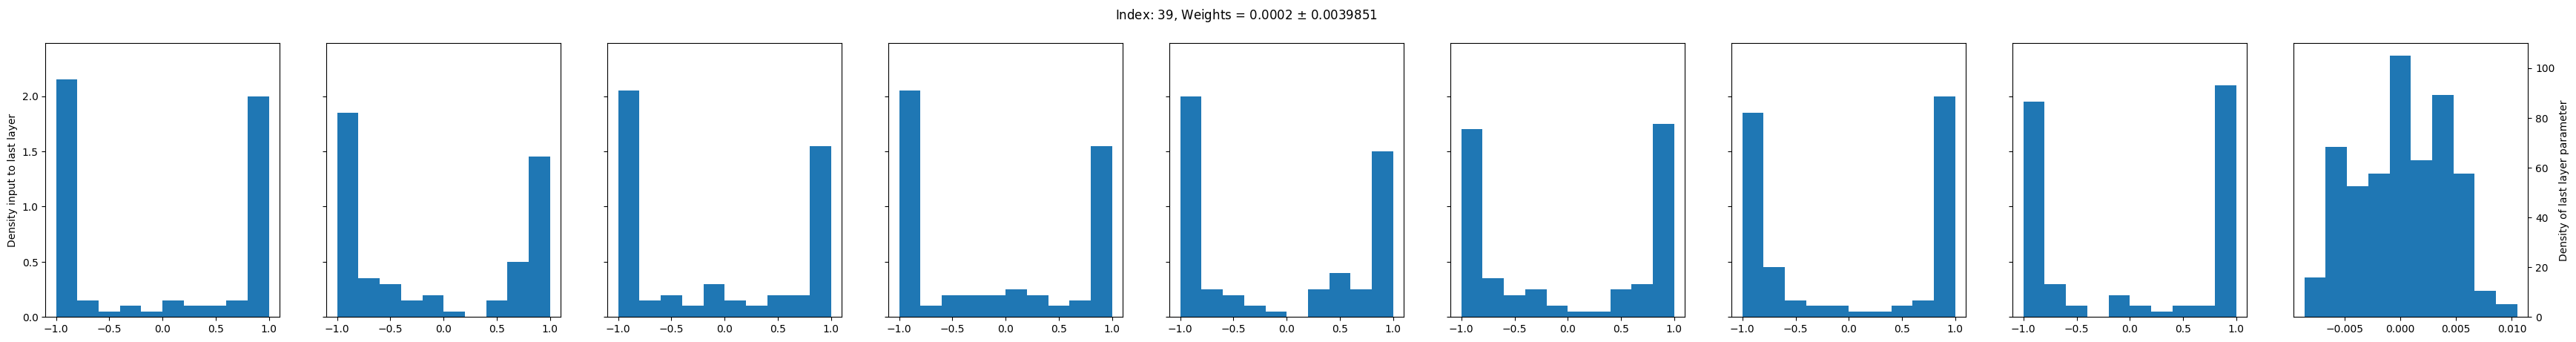

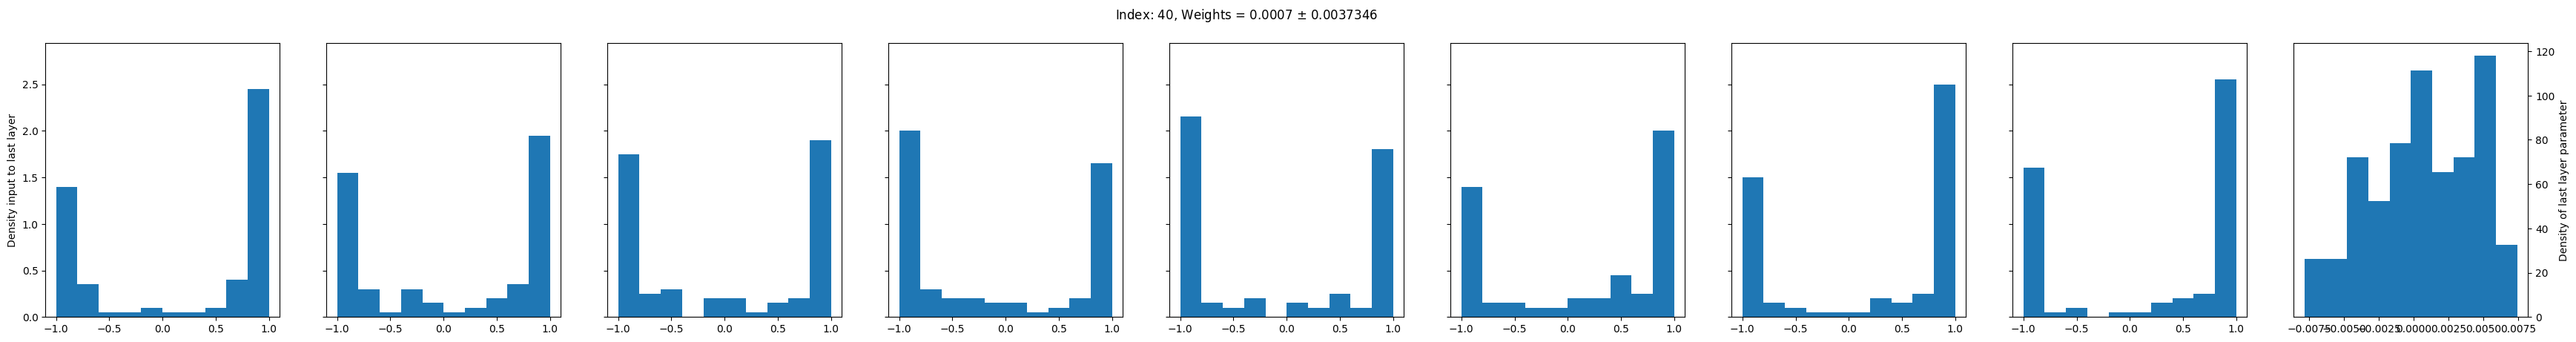

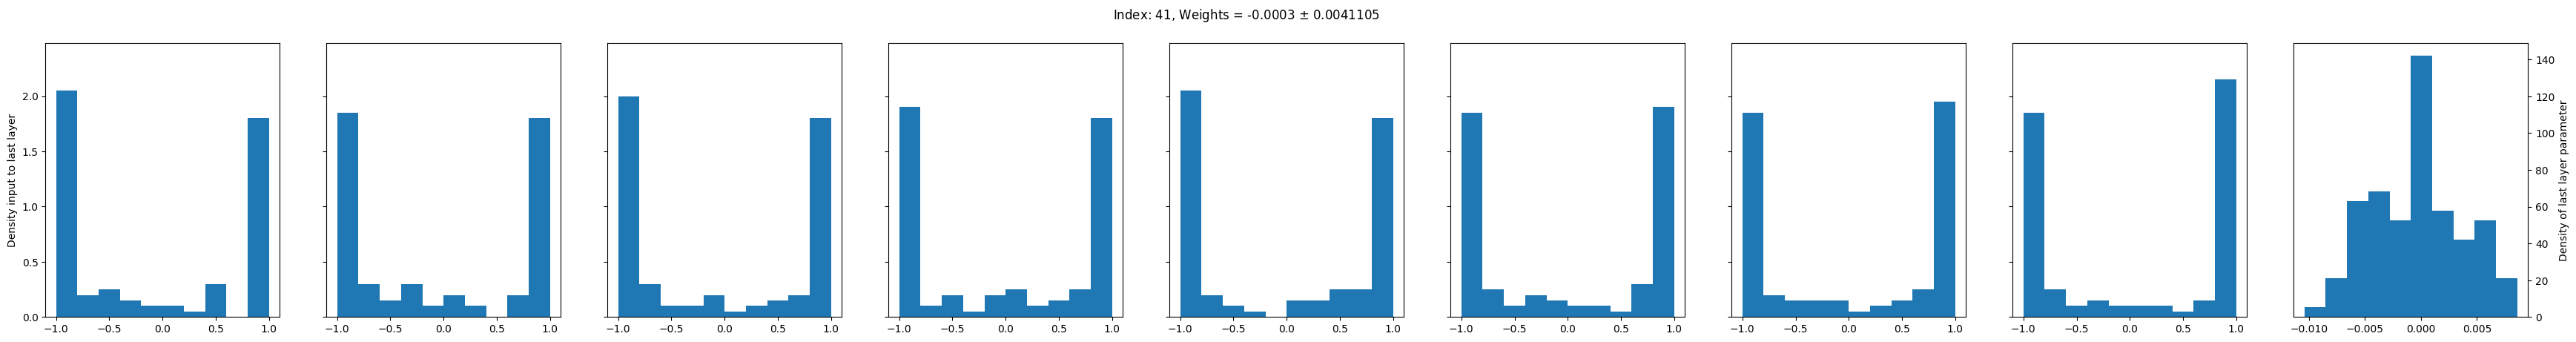

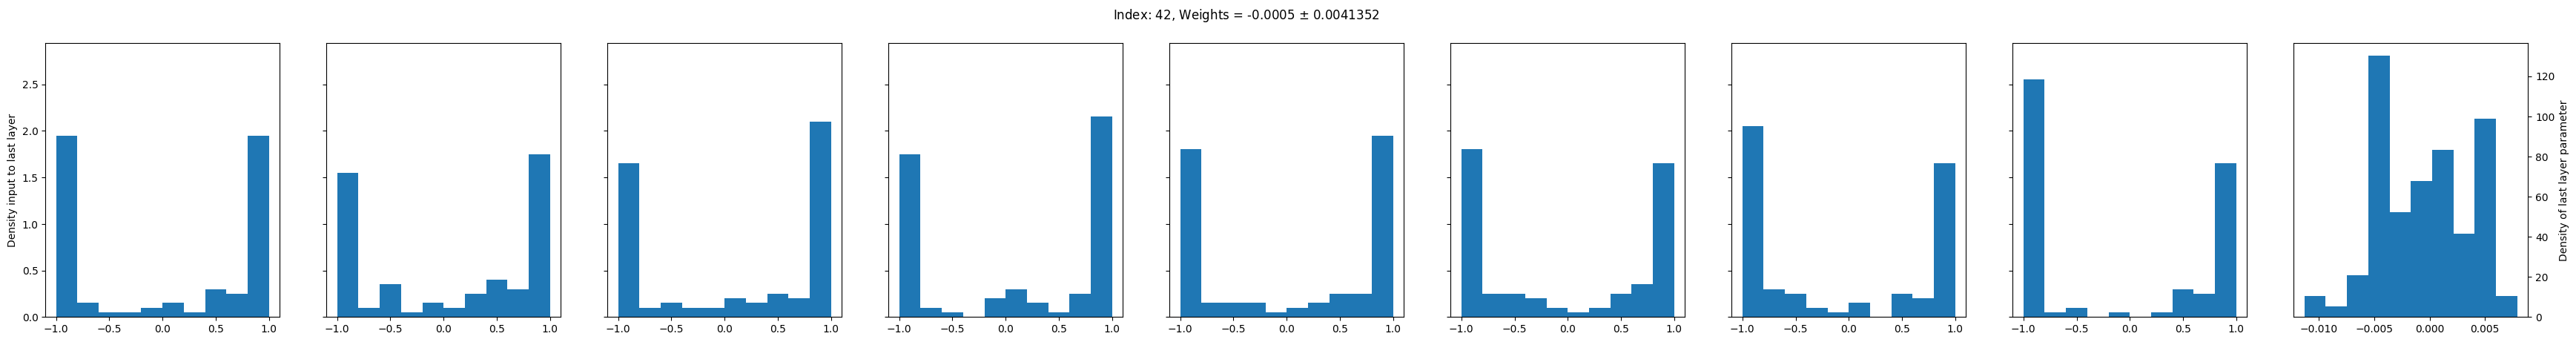

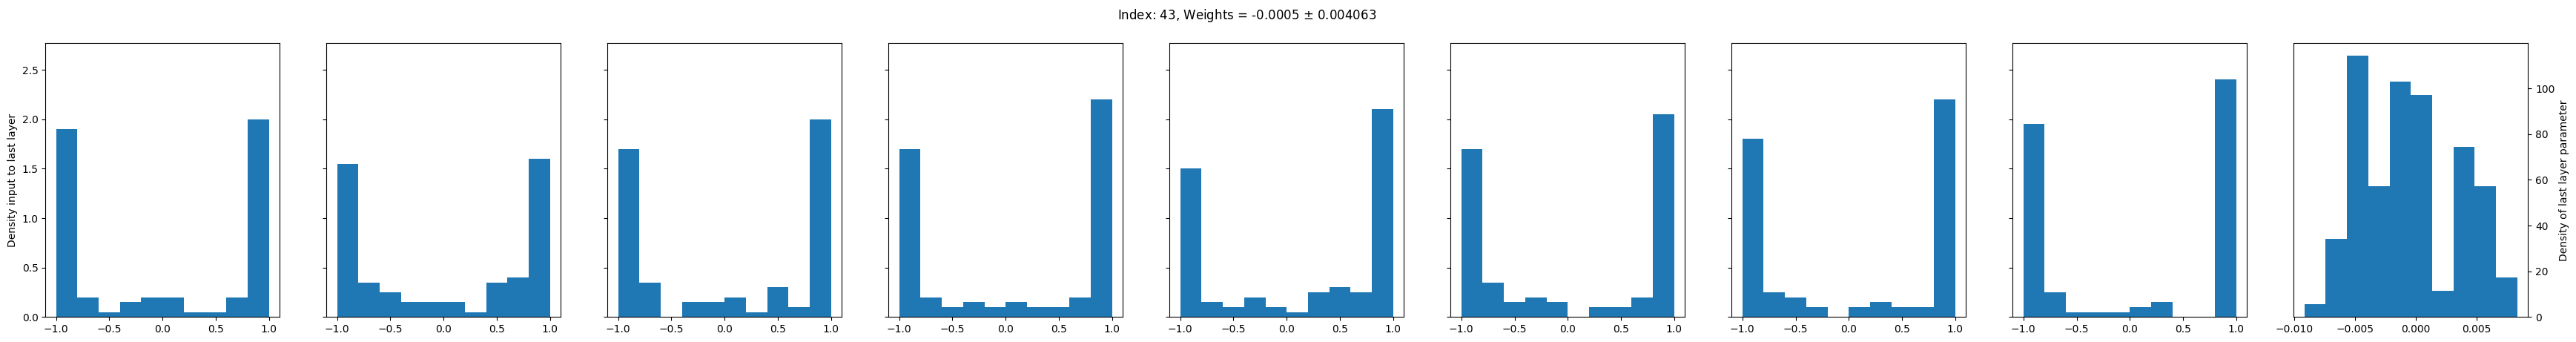

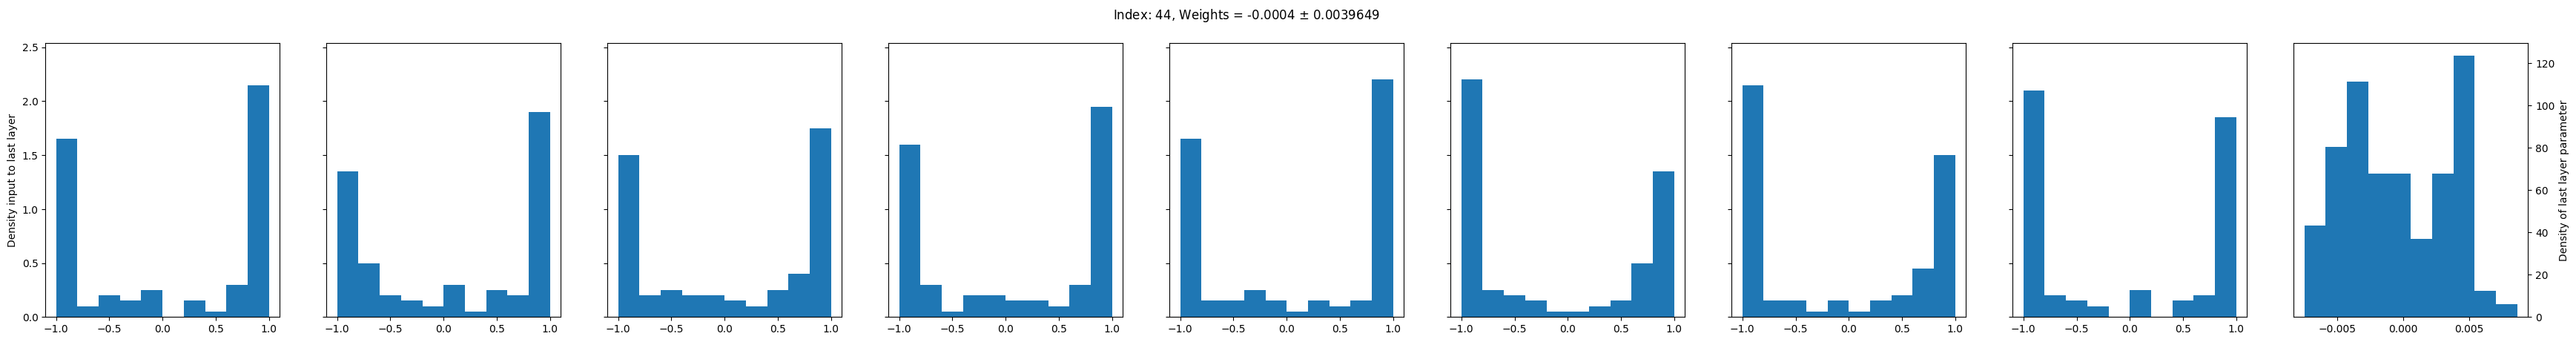

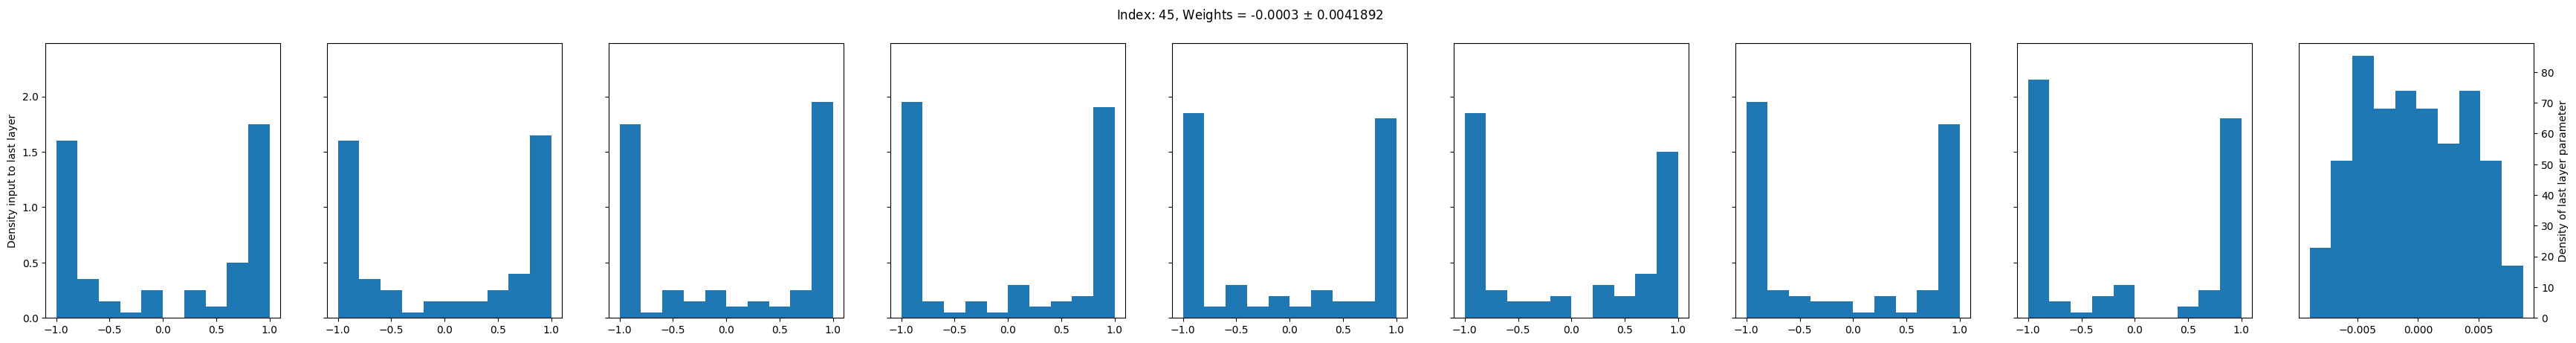

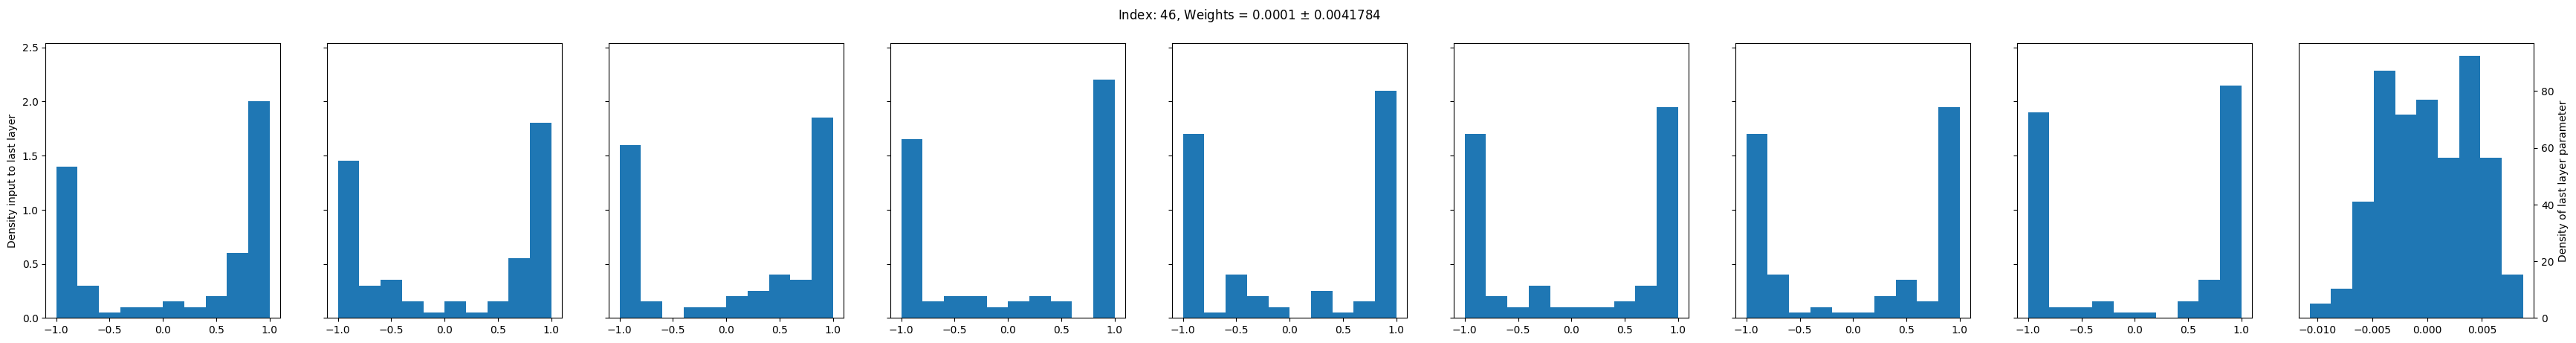

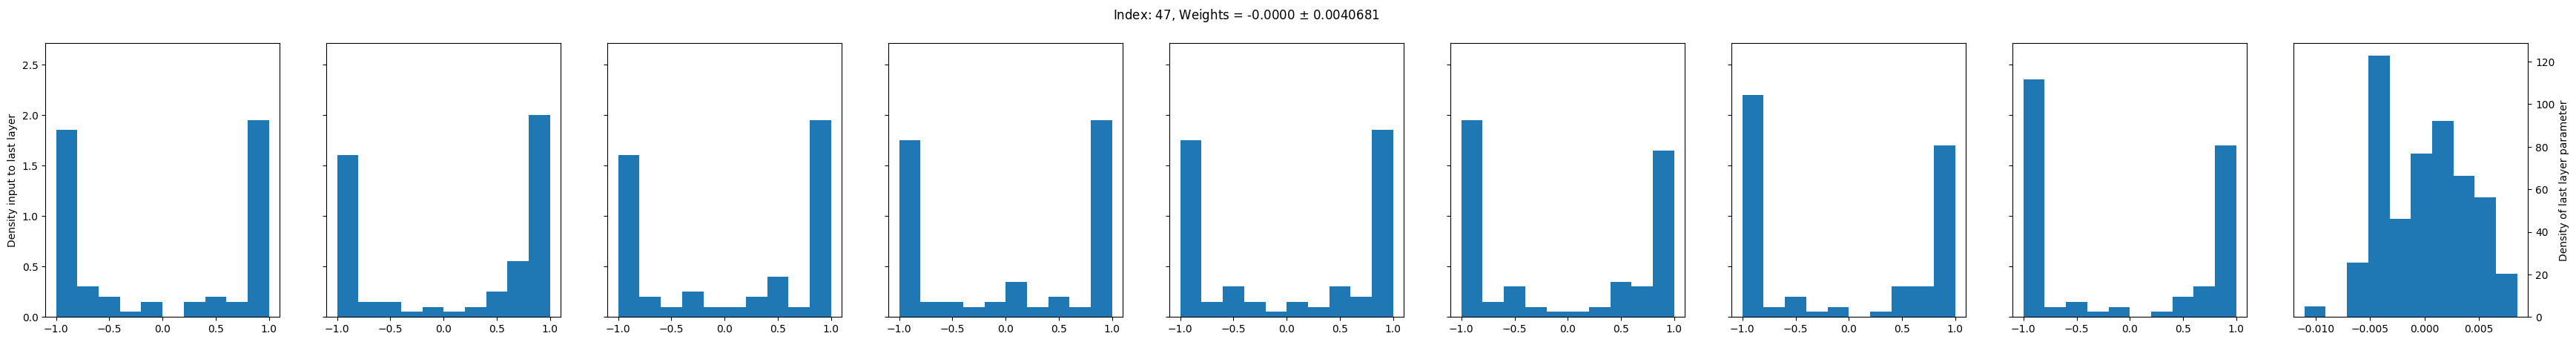

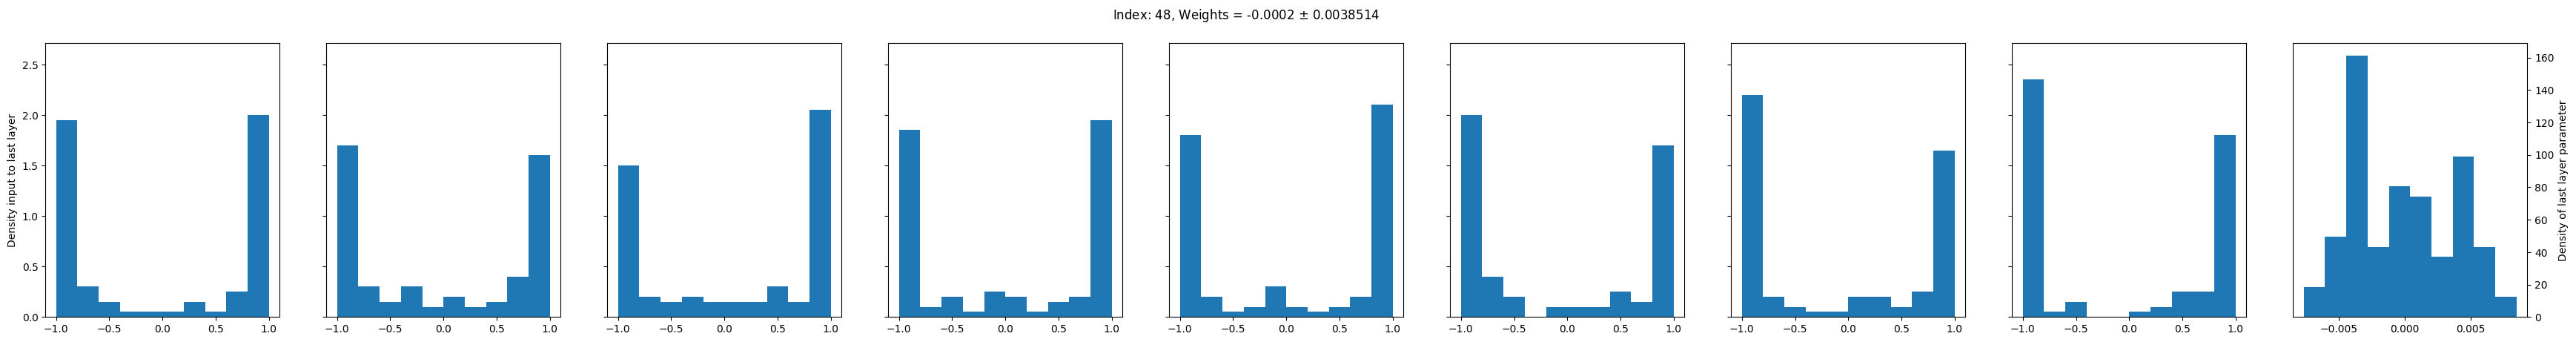

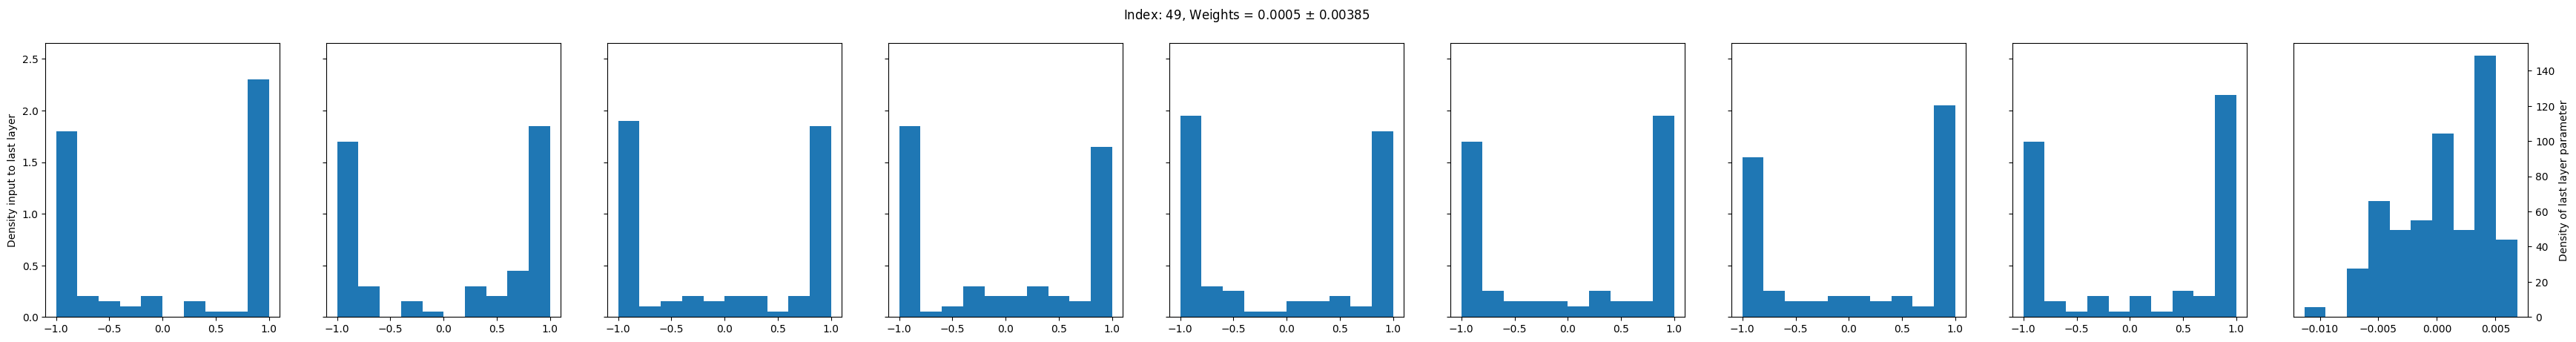

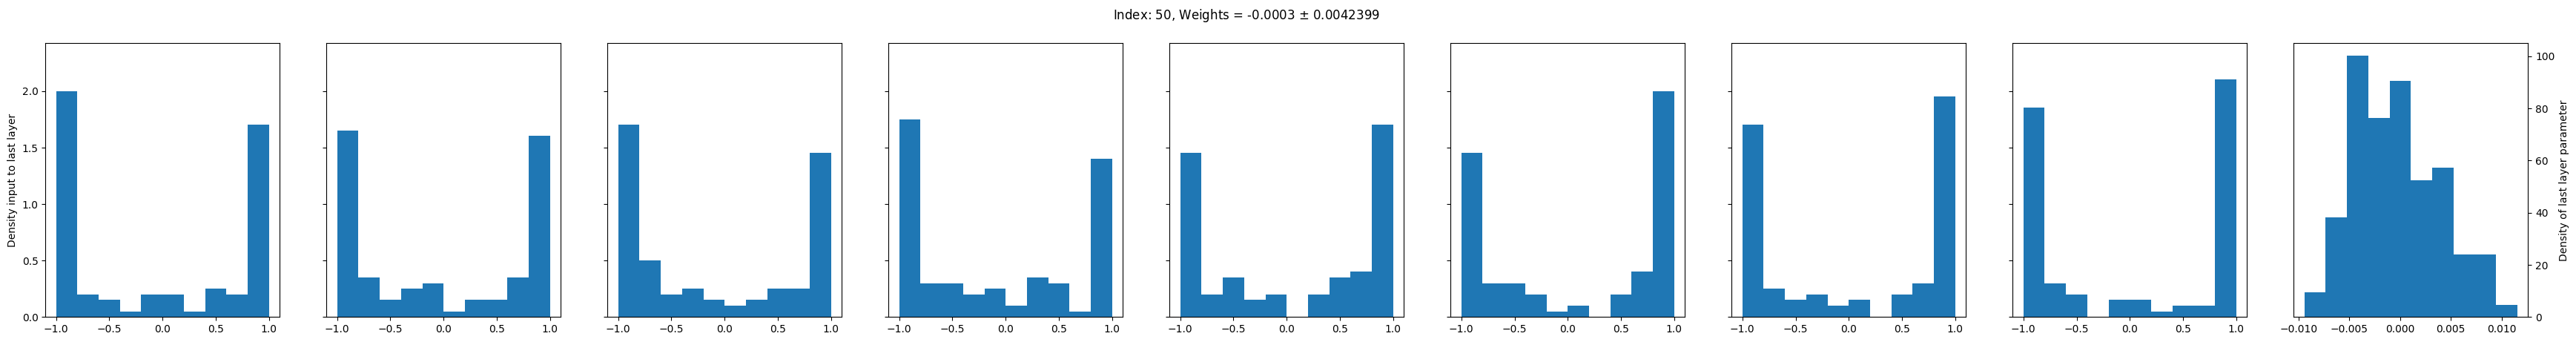

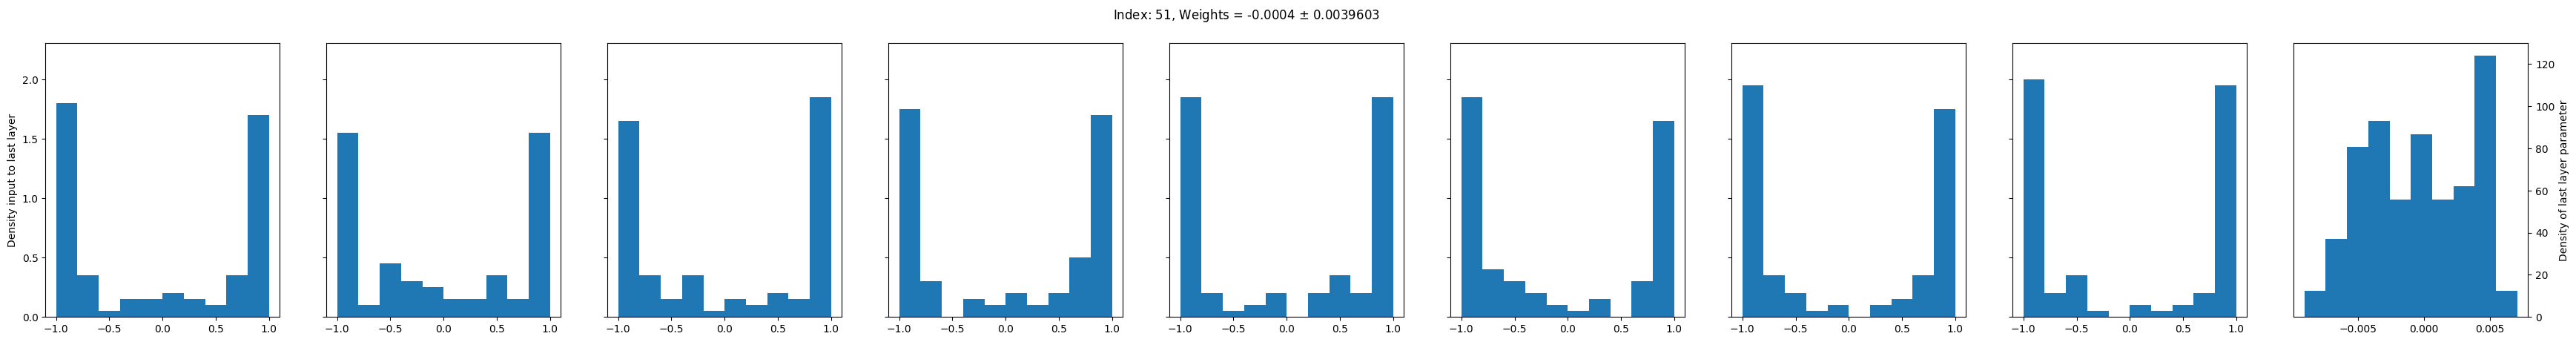

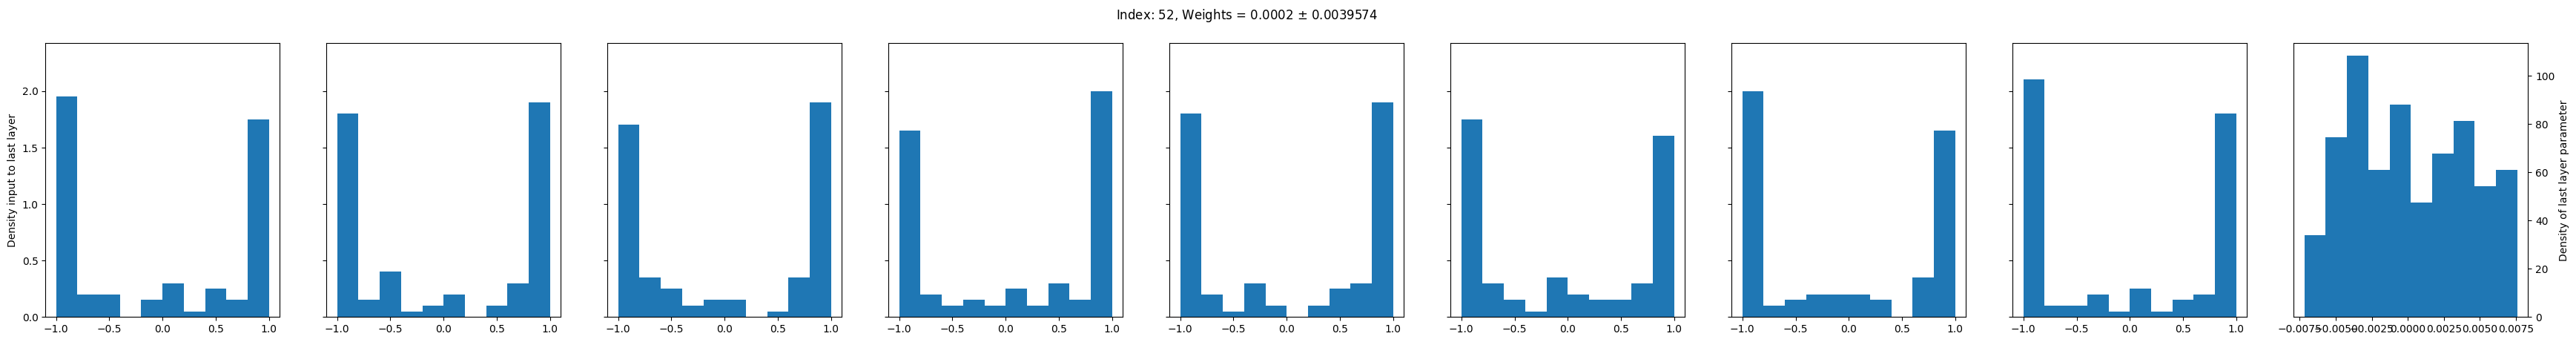

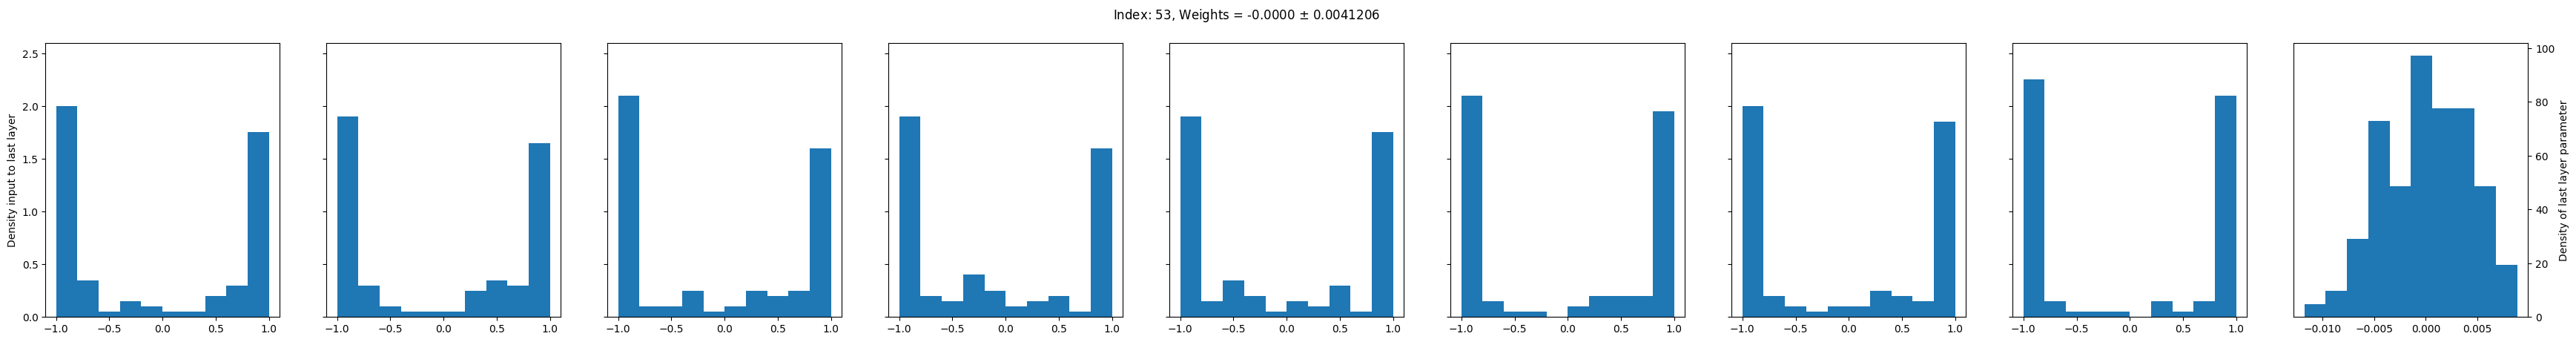

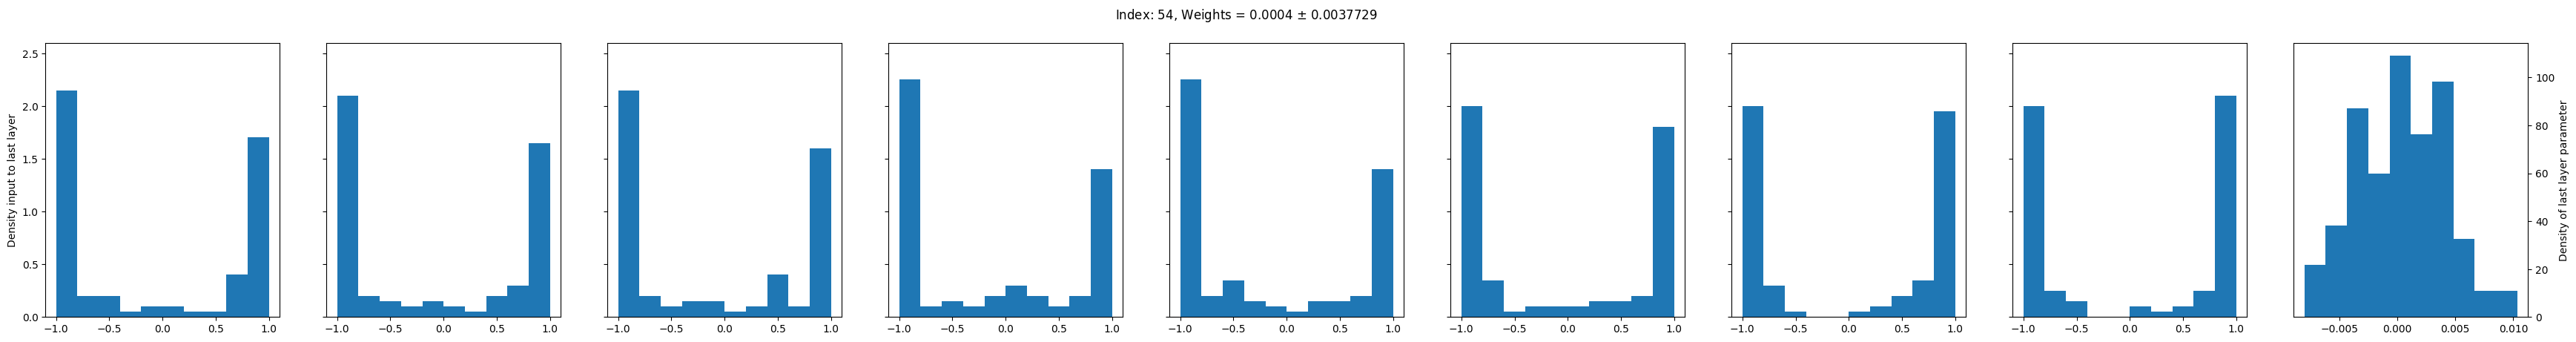

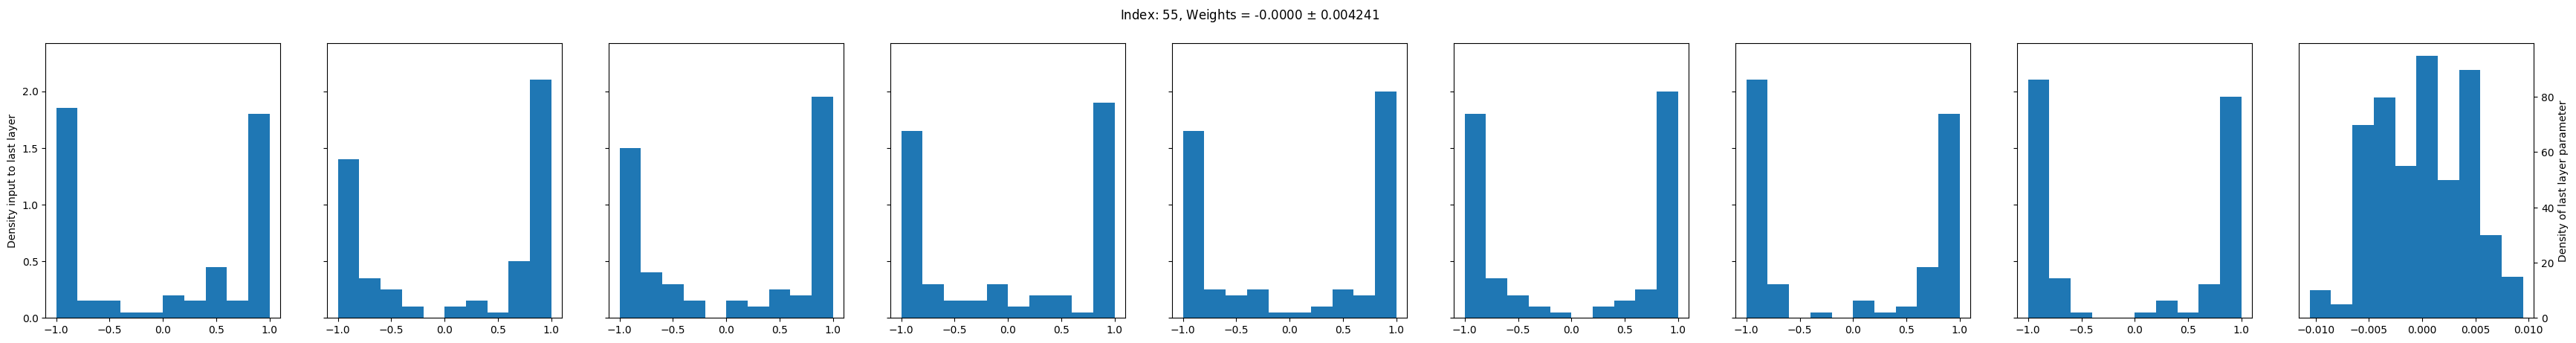

KeyboardInterrupt: 

In [13]:
# # Plot the distributions of input and parameters of the last layer
# for ii in range(output_activation.shape[-1]):
#     fig, axes = plt.subplots(1, len(aidx) + 1, figsize=(4.8 * (len(aidx) + 1), 4.8))
#     fig.suptitle(f"Index: {ii}, Weights = {llp_mean[ii]:0.4f} $\pm$ {llp_std[ii]:0.5}")
#     ylim_max = []
#     for jj, ai in enumerate(aidx):
#         ax = axes[jj]
#         ax.hist(output_activation[:, ai, ii], density=True, bins=10)
#         if jj == 0:
#             ax.set_ylabel("Density input to last layer")
#         else:
#             ax.set_yticklabels([])
#         # ylim to simulate sharey=True
#         ylim_max.append(ax.get_ylim()[1])
#     for jj in range(len(aidx)):
#         ax = axes[jj]
#         ax.set_ylim(0, 1.1 * max(ylim_max))
#     # Add the plot of distribution of weights
#     ax = axes[-1]
#     ax.hist(last_layer_params[:, ii], density=True, bins=10)
#     ax.yaxis.tick_right()  # Moves tick labels to the right
#     ax.yaxis.set_ticks_position("right")  # Moves ticks to the right
#     ax.yaxis.set_label_position("right")  # Moves label to the right
#     ax.set_ylabel("Density of last layer parameter")  # Set axis label
# plt.show()